Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC3641 - Aprendizaje Automático Basado en Grafos <br>
Segundo Semestre 2025<br>


<h1><center> Tarea 3  </center></h1>
        Profesor: Marcelo Mendoza<br>
        Fecha de entrega: 22 de octubre


---

## Indicaciones

Se debe entregar **SOLO** el archivo .ipynb en el buzón respectivo en canvas.

**IMPORTANTE**:
- Se asignará puntaje por el código implementado y los comentarios asociados a resultados.
- El notebook debe tener todas las celdas de código ejecutadas.
- Cualquier instancia de copia resultará en un 1.1 como nota de curso.

---

# Integrantes del grupo

* Estudiante 1: Felipe Vidal
* Estudiante 2: Vittorio Salvatore

# Librerías

### Parte 1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
import torch
import torch.nn as nn
import torch.nn.functional as F
import dgl
import dgl.function as fn
from dgl import DGLGraph
from dgl.nn.pytorch import RelGraphConv
from matplotlib.lines import Line2D
from networkx.algorithms import approximation as approx
import networkit as nk
from multiprocessing import Pool, cpu_count
from multiprocessing.pool import ThreadPool
from functools import partial
from tqdm import tqdm
import random

/home/felipe/iic3641-gml/repo/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
import os
os.environ["DGLBACKEND"] = "pytorch"

### Parte 2

In [ ]:
import logging
import importlib
from tdc import utils
import random
from itertools import product

import rdkit
from rdkit import RDLogger
import torch
from torch import nn
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.loader import DataLoader
import gt_pyg
from gt_pyg.gt_pyg.data.utils import (
    get_tensor_data,
    get_node_dim,
    get_edge_dim,
    get_train_valid_test_data
)
from gt_pyg.gt_pyg.nn.model import GraphTransformerNet
from gt_pyg.gt_pyg.nn.gt_conv import GTConv
from torch_geometric.data import Data
import torchmetrics
from torchmetrics import MeanAbsoluteError
device = torch.device('cuda')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns

### Parte 3

In [3]:
import os
import math
import random
import numpy as np
from dataclasses import dataclass

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import torch_geometric
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_dense_adj
from torch_geometric.nn import GCNConv, TransformerConv
from torch_geometric.utils import get_laplacian

# Funciones de pooling densas
from torch_geometric.nn.dense.diff_pool import dense_diff_pool
from torch_geometric.nn.dense.mincut_pool import dense_mincut_pool
import torch.nn.functional as F

from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


In [ ]:
torch.cuda.set_per_process_memory_fraction(0.8)

#Parte 1: Relational Graph Convolutional Network (R-GCN) (20 puntos)

En esta primera sección se trabaja con el dataset BGSDataset, disponible en dgl.

Ver enlace: https://www.dgl.ai/dgl_docs/generated/dgl.data.BGSDataset.html#dgl.data.BGSDataset

**Observación**

Para trabajar con el código visto en clases deben ajustar la versión de pytorch.

## 1.1 Conceptos básicos (5 puntos)


Responda las siguientes preguntas:

1. Mencione y describa los elementos que diferencian las arquitecturas **GCN** y **R-GCN**.

2. Explique las principales diferencias en el proceso de entrenamiento de arquitecturas basadas en **R-GCN**, considerando las tareas **Clasificación de nodos** y **Predicción de enlaces**

**Observación**

Para la pregunta 2 se recomienda revisar la publicación **Modeling
relational data with graph convolutional networks** (Schlichtkrull et al., 2018). Disponible en: https://arxiv.org/abs/1703.06103


Respuesta:

1.
Las GCN trabajan sobre grafos homogéneos, donde todos los nodos y enlaces son del mismo tipo. En este caso, la actualización de las representaciones se realiza combinando la información de los vecinos mediante una única matriz de pesos compartida, sin distinguir tipos de relaciones.

Las R-GCN, en cambio, extienden este modelo para grafos multirrelacionales o heterogéneos, donde existen distintos tipos de nodos y enlaces. Para manejar esto, definen un mecanismo de message passing que depende del tipo de relación: cada tipo de enlace tiene su propio conjunto de parámetros. Esto permite que el modelo capture la influencia específica de cada relación en la representación de los nodos. Cuando el número de relaciones es alto, las R-GCN usan un conjunto reducido de matrices base que se combinan linealmente para reducir la cantidad de parámetros.

En resumen, la GCN trata todas las conexiones por igual, mientras que la R-GCN diferencia las relaciones y aprende pesos específicos para cada una, lo que la hace adecuada para grafos de conocimiento o datos relacionales complejos.

2.
En clasificación de nodos, la R-GCN actúa como un codificador que genera representaciones para cada nodo, y la función de pérdida se aplica directamente sobre los nodos etiquetados, normalmente usando cross-entropy. El entrenamiento es transductivo: el modelo ve toda la estructura del grafo, aunque solo algunos nodos tengan etiqueta.

En predicción de enlaces, la R-GCN también genera embeddings de los nodos, pero se agrega un decoder que evalúa la probabilidad de que exista un enlace entre dos nodos. Esto se hace mediante un modelo de scoring, como DistMult, que calcula una puntuación basada en los vectores de las entidades y las relaciones. La pérdida se define para maximizar los puntajes de enlaces verdaderos y minimizar los de los falsos.

En otras palabras, la clasificación de nodos optimiza la pérdida sobre nodos etiquetados, mientras que la predicción de enlaces entrena sobre pares de nodos y tipos de relación, usando un modelo de puntuación.

Referencias:
- Clases 5 y 6 del curso.
- Modeling Relational Data with Graph Convolutional Networks (https://arxiv.org/pdf/1703.06103)

## 1.2 Análisis descriptivo (5 puntos)

Grafique el grafo y calcule medidas descriptivas para caracterizarlo. Comente sus resultados.

**Observación**

En caso de no poder graficar la red completa, se recomienda trabajar con un subconjunto de 15.000 nodos (demora cerca de 12 minutos). Esto **SOLO** aplica para este punto. **La actividad 1.3 debe considerar todo el grafo.**

Respuesta:

Cargamos el dataset

In [ ]:
dataset = dgl.data.BGSDataset()
graph = dataset[0]

category = dataset.predict_category
num_classes = dataset.num_classes

train_mask = graph.nodes[category].data['train_mask']
test_mask = graph.nodes[category].data['test_mask']
label = graph.nodes[category].data['label']

Done loading data from cached files.


In [ ]:
nx_graph = dgl.to_networkx(graph, node_attrs=['label'], edge_attrs=None)
G = nx.Graph(nx_graph)

Veamos si tenemos varias componentes y sus tamaños para decidir como tratarlas

In [ ]:
degrees = dict(G.degree())
is_connected = nx.is_connected(G)

if is_connected:
    G_lcc = G
else:
    largest_cc = max(nx.connected_components(G), key=len)
    G_lcc = G.subgraph(largest_cc).copy()

metrics = {
    "Número de nodos (grafo completo)": G.number_of_nodes(),
    "Número de aristas (grafo completo)": G.number_of_edges(),
    "Número de componentes conectadas": nx.number_connected_components(G),
    "Nodos en mayor componente": G_lcc.number_of_nodes(),
}

print("Métricas del grafo:")
for key, value in metrics.items():
    print(f"  {key}: {value}")

Métricas del grafo:
  Número de nodos (grafo completo): 94806
  Número de aristas (grafo completo): 280710
  Número de componentes conectadas: 18
  Nodos en mayor componente: 94746


Vemos que la componente conectada incluye prácticamente el grafo completo. Entre las otras 17 componentes solo existen 60 nodos en total. Podemos quedarnos con la mayor componente de forma segura sin y así evitar problemas sobre algunas métricas.

In [ ]:
G_main = G_lcc
G_nk = nk.nxadapter.nx2nk(G_main)

In [ ]:
diam_calc = nk.distance.Diameter(G_nk, algo=1)  # 1 = estimated upper bound
diam_calc.run()
diam = diam_calc.getDiameter()

def bfs_distances(source):
    bfs = nk.distance.BFS(G_nk, source=source, storePaths=False)
    bfs.run()
    return [d for d in bfs.getDistances() if d < float("inf")]

def estimate_average_distance_threaded(G, n_samples=100, seed=42, n_workers=8):
    random.seed(seed)
    nodes = list(range(G.numberOfNodes()))
    sample = random.sample(nodes, min(n_samples, len(nodes)))

    with ThreadPool(processes=n_workers) as pool:
        results = list(tqdm(pool.imap(bfs_distances, sample), total=len(sample), desc="Running BFS (threads)"))

    all_dists = [d for sub in results for d in sub]
    return np.mean(all_dists)

avg_dist = estimate_average_distance_threaded(G_nk, n_samples=1000)

print(f"Diámetro (aproximado): {diam}")
print(f"Distancia promedio (aproximada, 1000 muestras): {avg_dist:.4f}")

Running BFS (threads): 100%|██████████| 1000/1000 [00:10<00:00, 94.58it/s]


Diámetro (aproximado): (17, 0)
Distancia promedio (aproximada, 1000 muestras): 4.0227


In [ ]:
G_main = G_lcc

random.seed(42)
nodes_sample = random.sample(list(G_main.nodes()), 15000)
G_sample = G_main.subgraph(nodes_sample).copy()

degrees = dict(G_sample.degree())

metrics = {
    "Número de nodos": G_sample.number_of_nodes(),
    "Número de aristas": G_sample.number_of_edges(),
    "Densidad (aproximado, 15000 muestras)": nx.density(G_sample),
    "Grado promedio": np.mean(list(degrees.values())),
    "Coeficiente de clustering (aproximado, 15000 muestras)": nx.average_clustering(G_sample),
    "Grado máximo": max(degrees.values()),
    "Grado mínimo": min(degrees.values()),
    "Diámetro (aproximado)": diam[0],
    "Distancia promedio (aproximada, 1000 muestras)": avg_dist,
}

# --- Display metrics ---
df_metrics = pd.DataFrame(metrics.items(), columns=["Métrica", "Valor"])
df_metrics["Valor"] = df_metrics["Valor"].apply(
    lambda x: round(x, 4) if isinstance(x, (int, float, np.floating)) else x
)

display(df_metrics)

Métrica       Valor
0                                    Número de nodos  15000.0000
1                                  Número de aristas   6668.0000
2              Densidad (aproximado, 15000 muestras)      0.0001
3                                     Grado promedio      0.8891
4  Coeficiente de clustering (aproximado, 15000 m...      0.0031
5                                       Grado máximo    440.0000
6                                       Grado mínimo      0.0000
7                              Diámetro (aproximado)     17.0000
8     Distancia promedio (aproximada, 1000 muestras)      4.0227

Adicionalmente, antes de referirnos a las métricas, veamos el tipo de entidades que guarda el grafo.

In [ ]:
# --- Información básica ---
print("Número de tipos de nodo:", len(graph.ntypes))
print("Número de tipos de borde (canónicos):", len(graph.canonical_etypes), "\n")

category = dataset.predict_category
print(f"Categoría de predicción (tipo de nodo objetivo): {category}")

# --- Resumen de tipos de nodos ---
for ntype in graph.ntypes:
    num_nodes = graph.num_nodes(ntype)
    print(f"\nTipo de nodo: {ntype} ({num_nodes} nodos)")
    print("Keys de datos de nodo:", graph.nodes[ntype].data.keys())


Número de tipos de nodo: 27
Número de tipos de borde (canónicos): 122 

Categoría de predicción (tipo de nodo objetivo): Lexicon/NamedRockUnit

Tipo de nodo: 625KGeologyMap/Dyke (3263 nodos)
Keys de datos de nodo: dict_keys(['_ID'])

Tipo de nodo: 625KGeologyMap/Rank (9 nodos)
Keys de datos de nodo: dict_keys(['_ID'])

Tipo de nodo: 625KGeologyMap/Unit (11244 nodos)
Keys de datos de nodo: dict_keys(['_ID'])

Tipo de nodo: EarthMaterialClass/ComponentRank (6 nodos)
Keys de datos de nodo: dict_keys(['_ID'])

Tipo de nodo: EarthMaterialClass/ComponentRelation (35 nodos)
Keys de datos de nodo: dict_keys(['_ID'])

Tipo de nodo: EarthMaterialClass/RockComponent (1542 nodos)
Keys de datos de nodo: dict_keys(['_ID'])

Tipo de nodo: EarthMaterialClass/RockComposite (616 nodos)
Keys de datos de nodo: dict_keys(['_ID'])

Tipo de nodo: EarthMaterialClass/RockName (3605 nodos)
Keys de datos de nodo: dict_keys(['_ID'])

Tipo de nodo: Geochronology/Boundary (276 nodos)
Keys de datos de nodo: dict_key

In [ ]:
print("Split de nodos por entrenamiento y prueba:")
print("    Nodos de entrenamiento:", train_mask.sum().item())
print("    Nodos de prueba:", test_mask.sum().item())
print("    Total de nodos etiquetados:", (train_mask | test_mask).sum().item())
print("    Total de nodos en la categoría:", len(label))

print("\nSplit de nodos por etiqueta en la categoría objetivo:")
nodes_per_label = {}
for key in graph.nodes[category].data['label'].unique():
    count = (graph.nodes[category].data['label'] == key).sum().item()
    if key.item() != -1:
        nodes_per_label[key] = count
    print(f"    Label {key}: {count} nodos")
print("    Total de nodos etiquetados: ", sum(nodes_per_label.values()))

Split de nodos por entrenamiento y prueba:
    Nodos de entrenamiento: 117
    Nodos de prueba: 29
    Total de nodos etiquetados: 146
    Total de nodos en la categoría: 18002

Split de nodos por etiqueta en la categoría objetivo:
    Label -1: 17856 nodos
    Label 0: 93 nodos
    Label 1: 53 nodos
    Total de nodos etiquetados:  146


### Análisis cuantitativo y cualitativo
Estamos trabajando con una muestra aleatoria de 15k nodos, proveniente del grafo original con cerca de 90k nodos.

Viendo el número de aristas de este subgrafo, así como la densidad y grado promedio, vemos que este es bastante disperso. Con una densidad aproximada de 0.0001 y un grado promedio de 0.89, la mayoría de los nodos están muy poco conectados (llegan a tener incluso menos de un vecino en promedio). Si bien la muestra es aleatoria y debería ser a priori representativa del grafo completo, es cierto que ciertas aristas y conexiones desaparecen al tomar 15k nodos aleatorios.

Mirando tanto el coeficiento de clustering aproximado de 0.0031, y el grado máximo de 440, nos damos cuenta de varias cosas. Los nodos no forman comunidades, por lo que rara vez están conectados entre sí. Al mismo tiempo, tenemos nodos super-conectados que contrastan fuertemente con el grado promedio, lo cual se puede esperar de un grafo heterogéneo, con cierta jerarquía entre sus nodos. Y es que el dataset BGS corresponde a información geológica detallada y dispuesta en diversos tipos de nodos. Algunos se refieren a entidades nombradas, mientras que otros se refieren a características de esas mismas entidades, y otros son formas de relación entre las entidades. Es decir, habrán ciertos nodos que serán acompañados por muchos otros, mientras que habrán otros cuyo único rol es describir a otro nodo. Por las cifras, probablemente haya muchos más del segundo tipo.

Finalmente, viendo el diámetro aproximado de 17 y la distancia promedio aproximada de 4.0227, nos damos cuenta de que si bien la red es dispersa, generalmente los nodos on están demasiado lejos entre sí. Esto puede deberse a estos nodos centrales que colapsan las distancias.

Ahora, ahondando en los tipos de entidades, vemos que tenemos muchos tipos de nodos, y más tipos de relaciones aún, con 27 y 122 respectivamente. La clase objetivo es Lexicon/NamedRockUnit con 18002 nodos. Vemos que es la única que tiene labels para tipos de clase, y que tiene máscara de entrenamiento y prueba. No obstante, de los 18002 nodos, solo 146 están etiquetados como train o test. Estos además coinciden con ser los únicos nodos con labels, en lo que parece ser una clasificación binaria.

### Gráficos del grafo

Teniendo en cuenta la gran variedad de tipos de nodos y relaciones, primero haremos un gráfico en base a 15000 nodos del grafo original, homogeneizado (sin considerar el tipo de arista) y coloreando los nodos por su tipo.

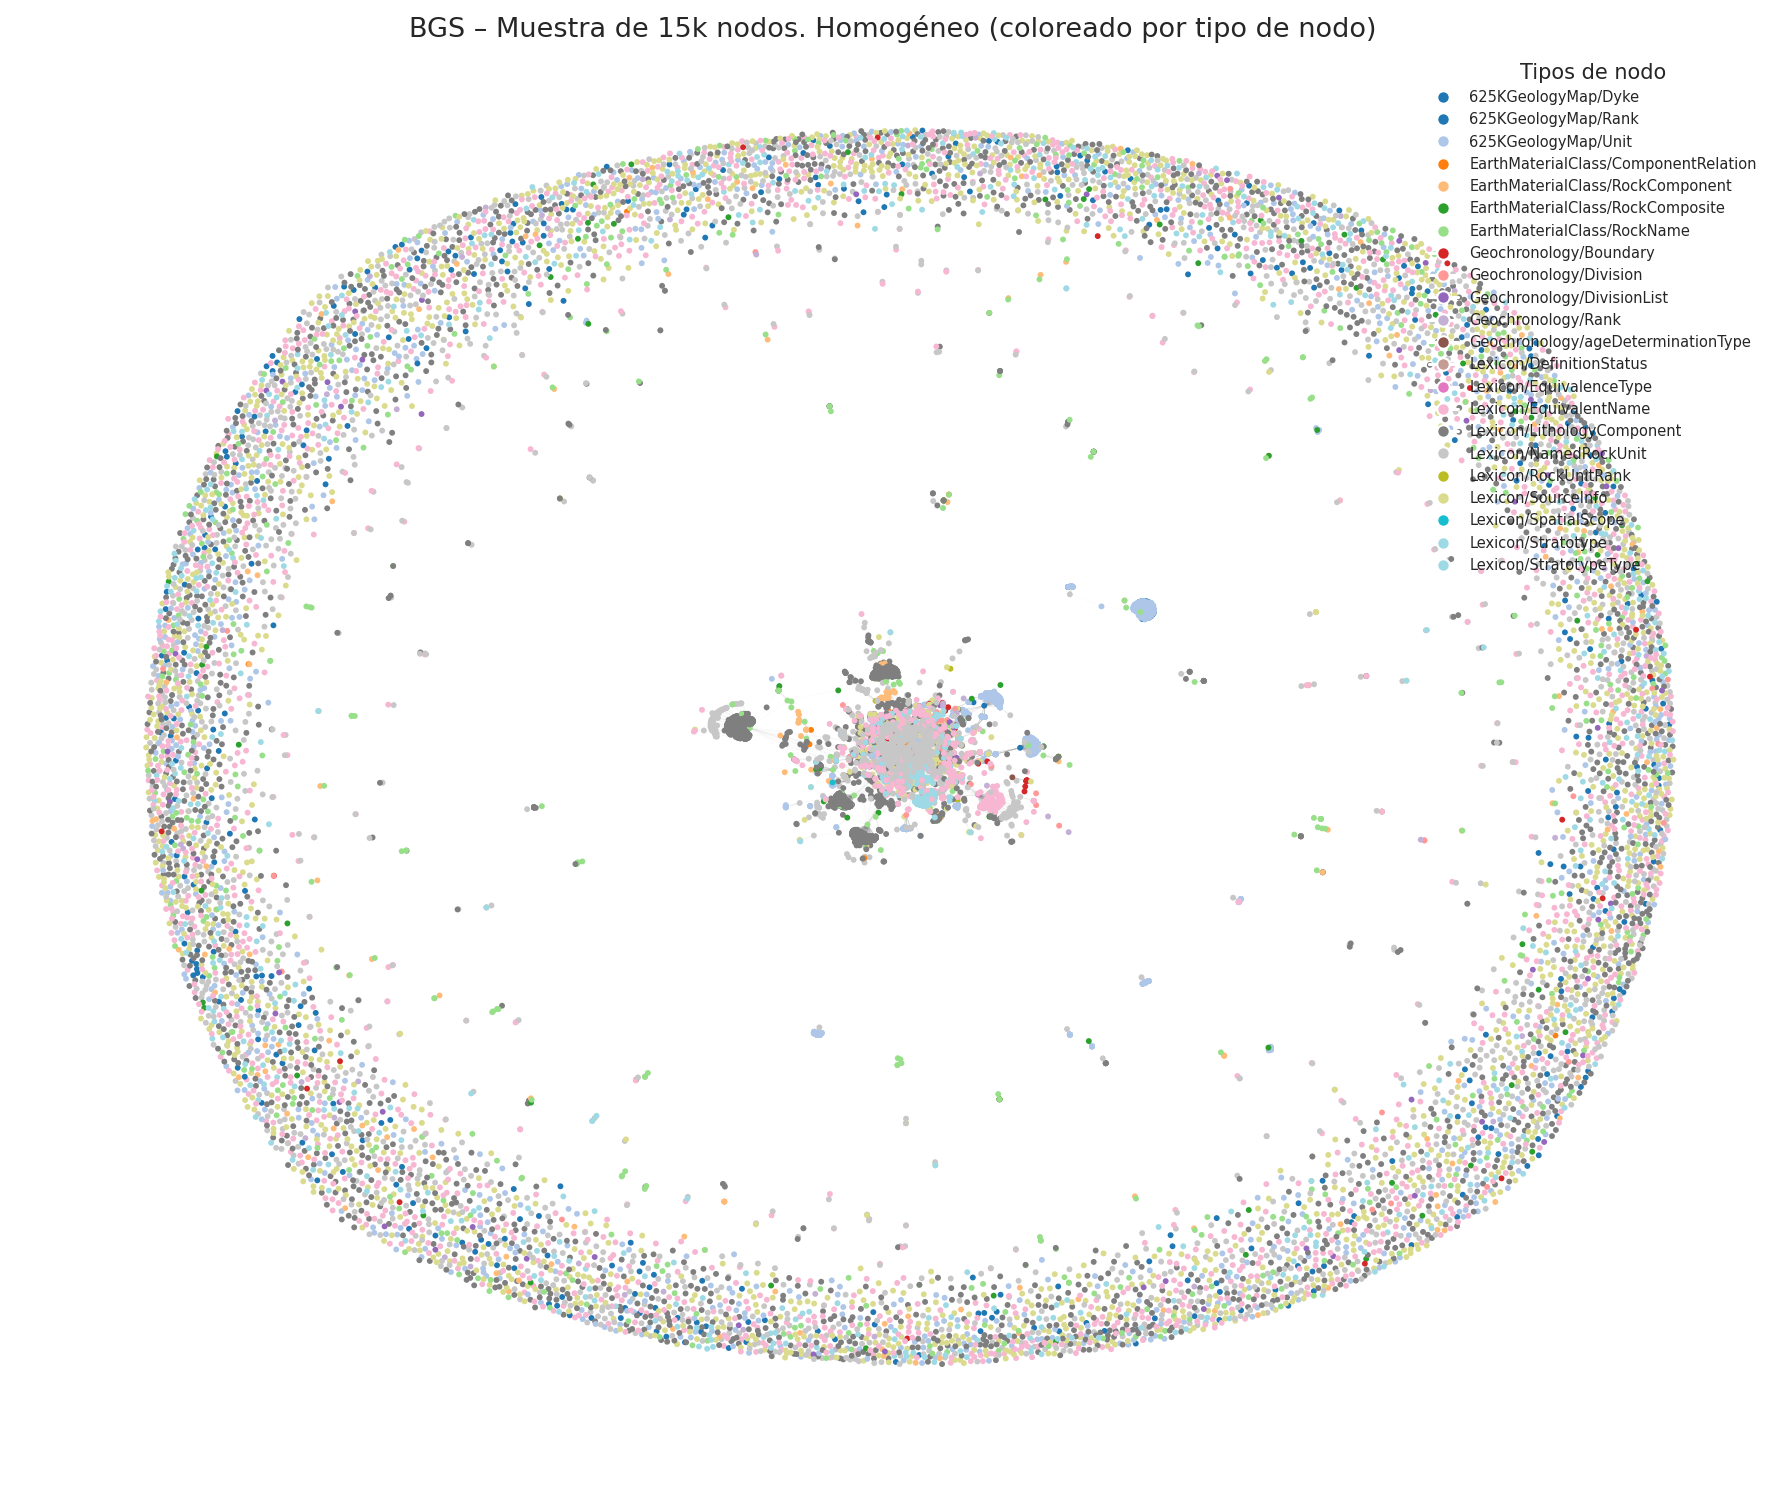

In [ ]:
graph_homo = dgl.to_homogeneous(graph)
node_type_ids = graph_homo.ndata[dgl.NTYPE].cpu().numpy()
type_names = graph.ntypes
num_types = len(type_names)

# --- Mapear IDs a nombres legibles
id_to_name = {i: n for i, n in enumerate(type_names)}

# --- Obtener los tipos de los nodos presentes en la muestra
node_ids = np.array(list(G_sample.nodes()))
node_type_for_sample = node_type_ids[node_ids]
unique_types = np.unique(node_type_for_sample)

# --- Asignar un color por tipo de nodo
cmap = plt.get_cmap("tab20")
colors = {tid: cmap(i / max(1, len(unique_types) - 1)) for i, tid in enumerate(unique_types)}
node_colors = [colors[tid] for tid in node_type_for_sample]

# --- Calcular layout
pos = nx.spring_layout(G_sample, seed=42, k=None)

# --- Dibujar
plt.figure(figsize=(12, 10), dpi=150)
nx.draw_networkx_edges(G_sample, pos, alpha=0.04, width=0.3, edge_color="gray")
nx.draw_networkx_nodes(G_sample, pos, node_color=node_colors, node_size=8, linewidths=0.0)

# --- Leyenda
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=id_to_name[tid],
           markerfacecolor=colors[tid], markersize=6)
    for tid in unique_types
]

plt.legend(
    handles=legend_elements,
    title="Tipos de nodo",
    fontsize=7,
    frameon=False,
    loc="center left",
    bbox_to_anchor=(1.02, 0.5),
)

plt.title("BGS – Muestra de 15k nodos. Homogéneo (coloreado por tipo de nodo)", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()


El grafo, debido a su gran número de nodos (y tipos) es difícil de apreciar en mucho detalle mediante spring-layout. No obstante, en el centro se observa un grupo denso formado principalmente por Lexicon/NamedRockUnit (la clase objetivo), Lexicon/LithologyComponent y Lexicon/EquivalentName. Esto puede estar alineado con la existencias de tipos de nodos que actúan como hubs (más conectados, al ser más relevantes jerárquicamente) y nodos menos conectados. En particular, estas clases mencionadas pueden ser aquellas con más conexiones, y aquellas encargadas de conectar realmente entidades entre sí (recordemos que el grafo original de 90k nodos, es conexo). En contraparte, los nodos que se ubican en la corona (y que tienen colores más variados) probablemente corresponden a las características de aquellos nodos super-conectados.

Ahora, podemos hacer un gráfico específico del tipo Lexicon/NamedRockUnit. Coloreamos según clasificación, pero como vimos antes, dado el desbalance entre nodos con etiqueta y sin etiquetar, dominarán la visualización los nodos sin etiqueta.

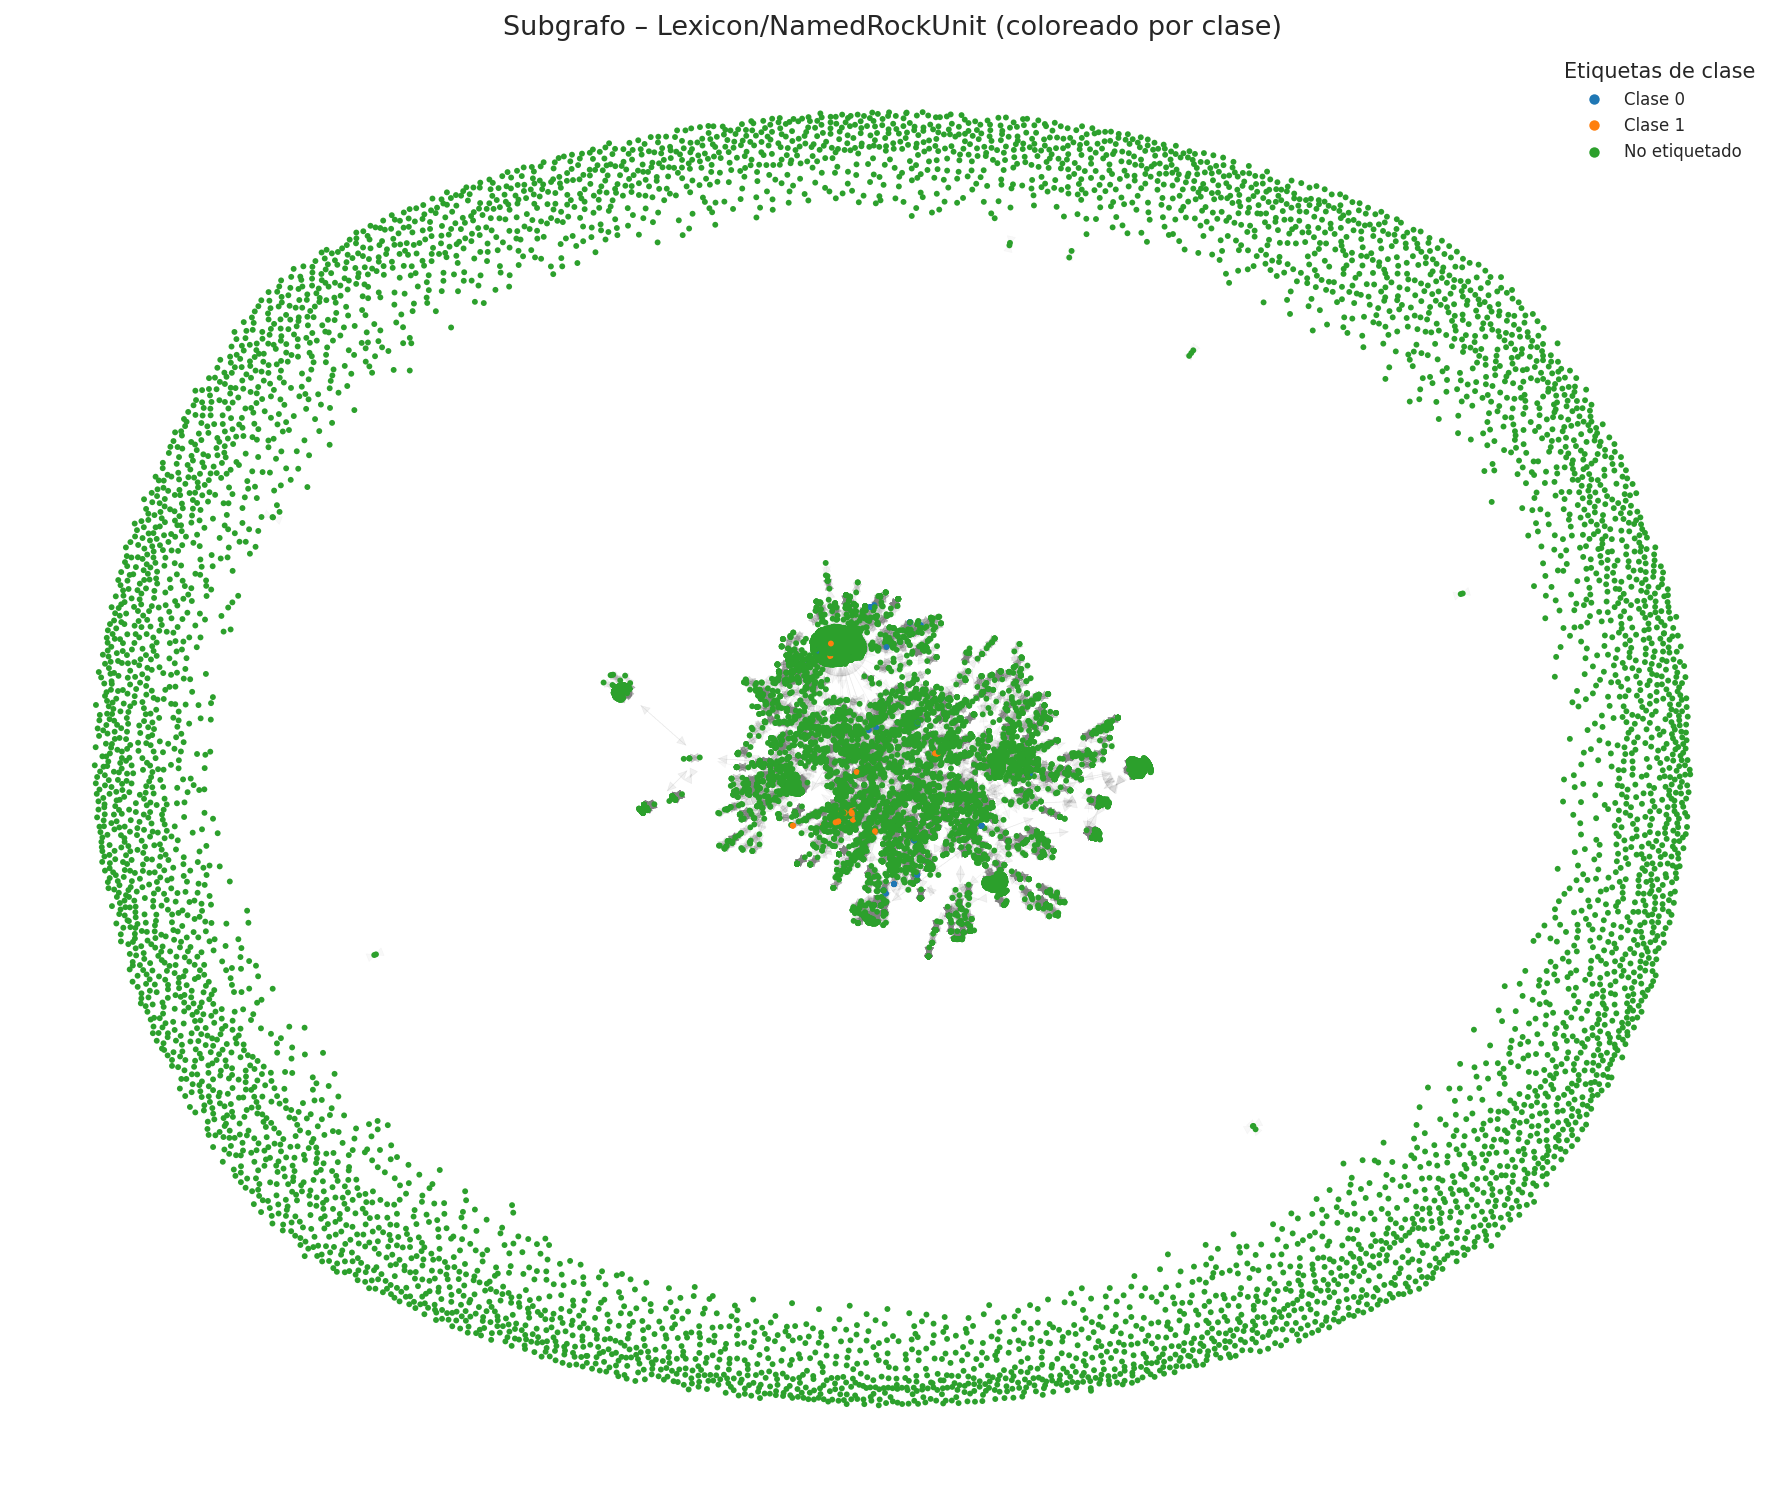

In [ ]:
# --- Tipo de nodo objetivo
tipo_objetivo = dataset.predict_category  # 'Lexicon/NamedRockUnit'

# --- Extraer subgrafo de ese tipo de nodo
subg = dgl.node_type_subgraph(graph, [tipo_objetivo])
subg_nx = dgl.to_networkx(subg)

# --- Obtener etiquetas
etiquetas = graph.nodes[tipo_objetivo].data["label"].cpu().numpy()

# --- Preparar colores: -1 (gris), 0 (azul), 1 (naranja)
cmap = { -1: "#2ca02c", 0: "#1f77b4", 1: "#ff7f0e" }
colores_nodos = [cmap.get(etiquetas[n], "#d3d3d3") for n in subg_nx.nodes()]

# --- Calcular layout
pos = nx.spring_layout(subg_nx, seed=42, k=None)

# --- Dibujar
plt.figure(figsize=(12, 10), dpi=150)
nx.draw_networkx_edges(subg_nx, pos, alpha=0.05, width=0.3, edge_color="gray")
nx.draw_networkx_nodes(subg_nx, pos, node_color=colores_nodos, node_size=8, linewidths=0.0)

# --- Leyenda discreta
legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Clase 0', markerfacecolor=cmap[0], markersize=6),
    Line2D([0], [0], marker='o', color='w', label='Clase 1', markerfacecolor=cmap[1], markersize=6),
    Line2D([0], [0], marker='o', color='w', label='No etiquetado', markerfacecolor=cmap[-1], markersize=6)
]
plt.legend(handles=legend_elements, title="Etiquetas de clase", fontsize=8, frameon=False, loc="upper right")

plt.title("Subgrafo – Lexicon/NamedRockUnit (coloreado por clase)", fontsize=13)
plt.axis("off")
plt.tight_layout()
plt.show()

En este gráfico se hace evidente el desbalance en etiquetado de la clase objetivo. Aquí estamos mostrando todos los nodos Lexicon/NamedRockUnit del grafo original (~18k nodos). Se alcanzan a ver algunos datos con etiqueta, en color naranjo y azul, pero son una inmensa minoría. Esto nos indica desde ya que el entrenamiento será complejo, ya que será difícil extraer información relevante desde solo 146 datos con etiqueta.

Finalmente, podemos realizar un metagrafo sobre las clases de nodos. Esto nos permitirá validar las ideas que surgieron desde el primer gráfico, al ver una abstracción.

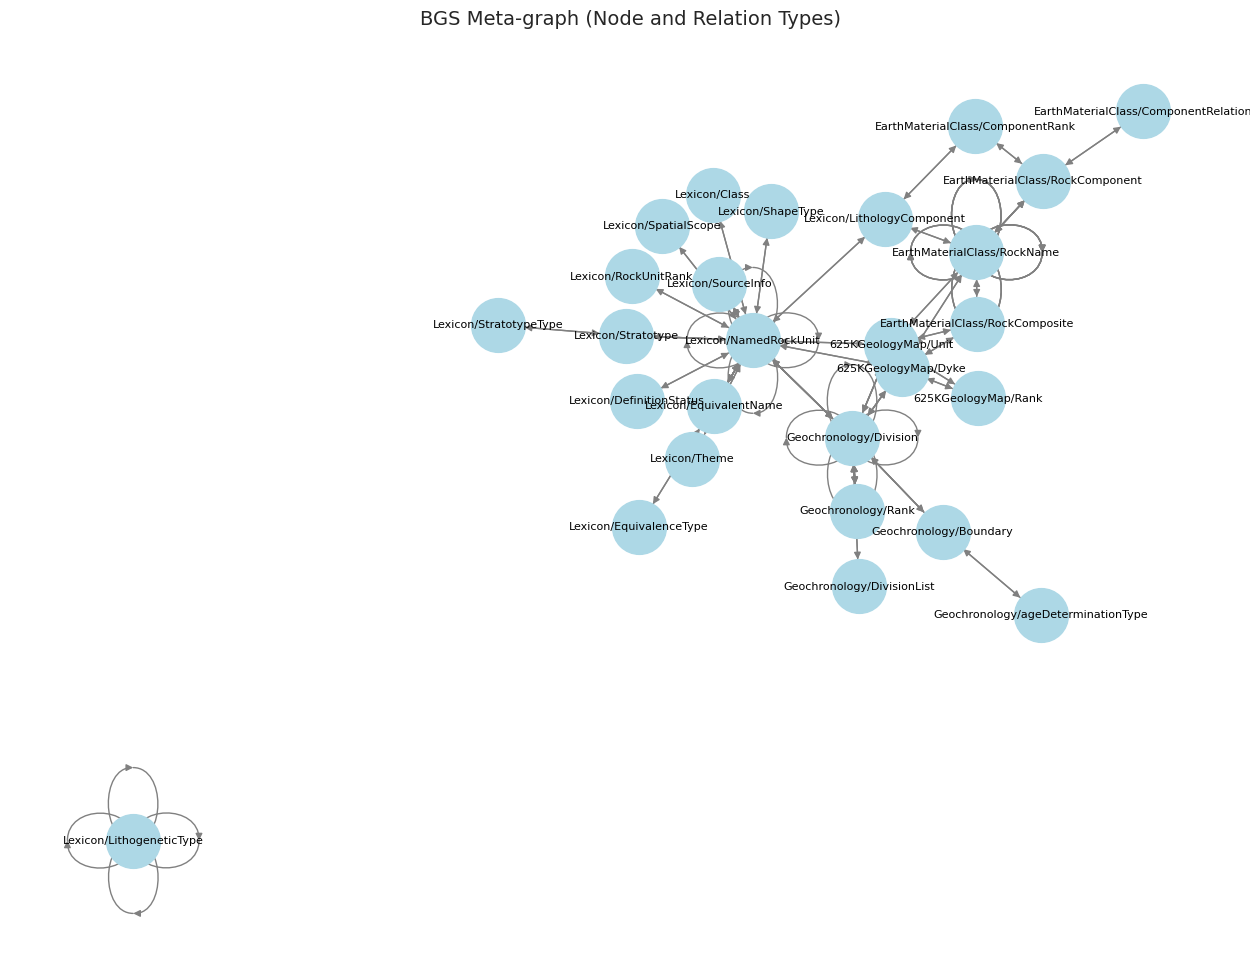

Meta-graph summary: 27 node types, 122 relation types


In [ ]:
meta = graph.metagraph()

plt.figure(figsize=(16, 12))
nx.draw_networkx(
    meta,
    with_labels=True,
    node_size=1500,
    node_color="lightblue",
    font_size=8,
    edge_color="gray",
    arrows=True,
)
plt.title("BGS Meta-graph (Node and Relation Types)", fontsize=14)
plt.axis("off")
plt.show()

print(f"Meta-graph summary: {meta.number_of_nodes()} node types, {meta.number_of_edges()} relation types")


Finalmente, podemos ver que todas los tipos de nodos (salvo LithogenicType) se relacionan directa o indirectamente entre sí. Nuestra hipótesis, de tener ciertos tipos nodos super-conectados, mientras que el resto solo se conecta con un tipo de entidad era correcta. NamedRockUnit, LithologyComponent y EquivalentName (junto con algunos más que probablemente por proporción no se notaron en el primer gráfico) conectan varios tipos de entidades en el grafo.

Esta estructura jerárquica será útil para el entrenamiento sobre la clase de interés, NamedRockUnit, pues si bien el resto de tipo de nodos no tiene más que que su etiqueta, si definen tipos de relaciones distintas que servirán para el contexto, especialmente usando R-GCN.

## 1.3 Implementación R-GCN (10 puntos)

Entrene una arquitectura R-GCN para clasificar entidades. Defina el número de épocas de manera que se garantice la convergencia del entrenamiento y justifique su elección de hiperpámetros.

Grafique la función de pérdida y accuracy. Comente sus resultados.

Respuesta:

Adaptamos el código visto en clases para manejar mejor un grafo mucho más grande, optimizando la construcción de la capa usando RelGraphConv de dgl, y la construcción de embeddings en la entrada. Además, la capa RelGraphConv permite hacer la transmisión de mensaje de forma sencilla en lugar de realizar manualmente el cálculo de matrices.

In [ ]:
class RGCNLayer(nn.Module):
    def __init__(
        self,
        in_dim,
        out_dim,
        num_rels,
        num_bases=-1,
        activation=None,
        is_input_layer=False,
        dropout=0.0,
    ):
        super().__init__()
        self.is_input_layer = is_input_layer
        self.activation = activation
        self.dropout = nn.Dropout(dropout) if dropout > 0 else None

        if is_input_layer:
            # in_dim se interpreta como "num_nodes" para la capa de entrada
            conv_in = out_dim
        else:
            conv_in = in_dim

        # Capa Relational Graph Convolution (usa IDs de edge-type del grafo homogéneo)
        self.conv = RelGraphConv(
            in_feat=conv_in,
            out_feat=out_dim,
            num_rels=num_rels,
            regularizer="basis" if (num_bases is None or num_bases > 0) else "none",
            num_bases=None if (num_bases is None or num_bases <= 0) else num_bases,
            bias=True,
            activation=activation,
            self_loop=True,
            dropout=dropout,
        )

    def forward(self, g):
        if self.is_input_layer:
            x = g.ndata["id"]
        else:
            x = g.ndata["h"]

        etypes = g.edata[dgl.ETYPE]
        edge_weight = g.edata["norm"].squeeze(1) if "norm" in g.edata else None

        # Reemplaza el cálculo manual de mensajes
        # También se encarga de activación y dropout
        h = self.conv(g, x, etypes, edge_weight)

        g.ndata["h"] = h
        return h

In [ ]:
class Model(nn.Module):
    def __init__(
        self,
        num_nodes,
        h_dim,
        out_dim,
        num_rels,
        num_bases=-1,
        num_hidden_layers=1,
        num_ntypes=0,
        dropout=0.0,
    ):
        super().__init__()
        self.num_nodes = num_nodes
        self.h_dim = h_dim
        self.out_dim = out_dim
        self.num_rels = num_rels
        self.num_bases = num_bases
        self.num_hidden_layers = num_hidden_layers
        self.dropout = dropout
        self.num_ntypes = num_ntypes
        self.node_type_embed = nn.Embedding(self.num_ntypes, self.h_dim)

        self.build_model() # crea capas R-GCN
        self.features = self.create_features() # crea features iniciales (IDs de nodo)

    def build_model(self):
        self.layers = nn.ModuleList()
        # input to hidden (ID -> embedding -> R-GCN)
        i2h = self.build_input_layer()
        self.layers.append(i2h)

        # hidden to hidden
        for _ in range(self.num_hidden_layers):
            h2h = self.build_hidden_layer()
            self.layers.append(h2h)

        # hidden to output
        h2o = self.build_output_layer()
        self.layers.append(h2o)

    def create_features(self):
        return nn.Parameter(torch.randn(self.num_nodes, self.h_dim))

    def build_input_layer(self):
        return RGCNLayer(
            in_dim=self.num_nodes,
            out_dim=self.h_dim,
            num_rels=self.num_rels,
            num_bases=self.num_bases,
            activation=F.relu,
            is_input_layer=True,
            dropout=self.dropout,
        )

    def build_hidden_layer(self):
        return RGCNLayer(
            in_dim=self.h_dim,
            out_dim=self.h_dim,
            num_rels=self.num_rels,
            num_bases=self.num_bases,
            activation=F.relu,
            is_input_layer=False,
            dropout=self.dropout,
        )

    def build_output_layer(self):
        return RGCNLayer(
            in_dim=self.h_dim,
            out_dim=self.out_dim,
            num_rels=self.num_rels,
            num_bases=self.num_bases,
            activation=partial(F.softmax, dim=1),
            is_input_layer=False,
            dropout=0.0,
        )

    def forward(self, g):
        # g debe ser grafo homogéneo

        if self.features is not None:
            h0 = self.features + self.node_type_embed(g.ndata[dgl.NTYPE])
            g.ndata["id"] = h0
        for layer in self.layers:
            layer(g)

        return g.ndata.pop("h")

In [ ]:
category_id = graph.ntypes.index(category)
node_ids = torch.arange(graph_homo.num_nodes())
target_idx_homo = node_ids[graph_homo.ndata[dgl.NTYPE] == category_id]

train_idx_homo = target_idx_homo[train_mask]
test_idx_homo  = target_idx_homo[test_mask]

train_idx_ab = train_idx_homo.clone()
test_idx_ab  = test_idx_homo.clone()
target_idx_ab = target_idx_homo.clone()

labels_cat = graph.nodes[category].data["label"]
labels_homo = torch.full((graph_homo.num_nodes(),), -1, dtype=torch.long)
labels_homo[target_idx_homo] = labels_cat

/tmp/ipykernel_1628/2837022269.py:6: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  train_idx_homo = target_idx_homo[train_mask]
/tmp/ipykernel_1628/2837022269.py:7: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  test_idx_homo  = target_idx_homo[test_mask]


Debemos decidir sobre varios hiperparámetros.

- El número de bases, que en el ejemplo de clases tomó -1 para usar tantas como relaciones haya, es demasiado alto para un grafo con 122 relaciones como BGS. Usaremos 30, para también aprovechar la descomposición de cada matriz por relación como una combinación lineal de estas 30 matrices.
- Para el dropout, utilizaremos un valor agresivo de 0.4. Esto permite controlar el overfitting que es mucho más probable con un dataset de entrenamiento y prueba tan pequeño.
- Para el número de épocas utilizaremos 300 con early stopping. De esta forma se tiene espacio de entrenar por un largo tiempo, pero cortando el entrenamiento una vez converja la pérdida.

Para n_hidden_layers (número de capas ocultas) y n_hidden (dimensiones de reducción de las capas ocultas), se probarán diversos valores en rangos estimados para ver cuáles rinden mejor. Para n_hidden_layers se usarán 0, 1 y 2 (valores bajos, pues cada capa añade parámetros que aumentan el riesgo de overfitting y relaciones lejanas sobre-representadas en forma de ruido). Para n_layers se utilizarán 32, 64 y 128 (nuevamente, más parámetros pueden llevar a overfitting en un contexto de entrenamiento y prueba acotado).

### Prueba de hiperparámetros

→ H=32, L=0, run=0
→ H=32, L=0, run=1
→ H=32, L=0, run=2
→ H=32, L=0, run=3
→ H=32, L=0, run=4
   ✓ mean_acc=0.683 ± 0.051, mean_loss=0.606

→ H=32, L=1, run=0
→ H=32, L=1, run=1
→ H=32, L=1, run=2
→ H=32, L=1, run=3
→ H=32, L=1, run=4
   ✓ mean_acc=0.669 ± 0.017, mean_loss=0.634

→ H=32, L=2, run=0
→ H=32, L=2, run=1
→ H=32, L=2, run=2
→ H=32, L=2, run=3
→ H=32, L=2, run=4
   ✓ mean_acc=0.572 ± 0.074, mean_loss=0.726

→ H=64, L=0, run=0
→ H=64, L=0, run=1
→ H=64, L=0, run=2
→ H=64, L=0, run=3
→ H=64, L=0, run=4
   ✓ mean_acc=0.662 ± 0.040, mean_loss=0.639

→ H=64, L=1, run=0
→ H=64, L=1, run=1
→ H=64, L=1, run=2
→ H=64, L=1, run=3
→ H=64, L=1, run=4
   ✓ mean_acc=0.676 ± 0.060, mean_loss=0.631

→ H=64, L=2, run=0
→ H=64, L=2, run=1
→ H=64, L=2, run=2
→ H=64, L=2, run=3
→ H=64, L=2, run=4
   ✓ mean_acc=0.669 ± 0.017, mean_loss=0.648

→ H=128, L=0, run=0
→ H=128, L=0, run=1
→ H=128, L=0, run=2
→ H=128, L=0, run=3
→ H=128, L=0, run=4
   ✓ mean_acc=0.703 ± 0.041, mean_loss=0.605

→ H=128,

n_hidden  n_hidden_layers  mean_acc   std_acc  mean_loss  std_loss
0       128                0  0.703448  0.041379   0.605232  0.041699
1        32                0  0.682759  0.050679   0.605895  0.047141
2        64                1  0.675862  0.060123   0.631394  0.058390
3        64                2  0.668966  0.016893   0.647949  0.013970
4        32                1  0.668966  0.016893   0.634293  0.014000
5        64                0  0.662069  0.040213   0.639269  0.043041
6       128                1  0.627586  0.059326   0.676089  0.057069
7       128                2  0.620690  0.065426   0.690919  0.065968
8        32                2  0.572414  0.074278   0.726033  0.076095

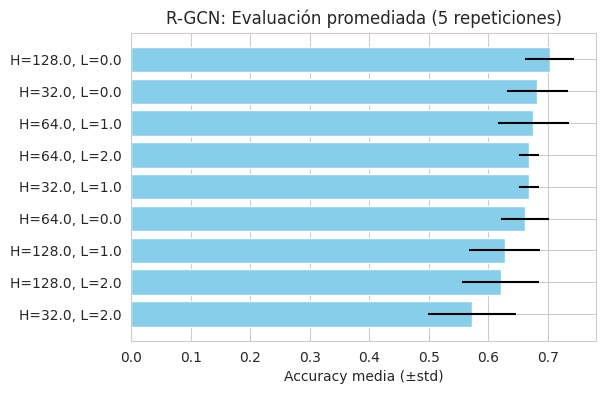

In [ ]:
def make_sample_nodes(sample_ratio=0.3):
    num_nodes = graph_homo.num_nodes()
    sample_size = int(num_nodes * sample_ratio)
    labeled_h = torch.cat([train_idx_ab, test_idx_ab]).unique()
    remaining = list(set(range(num_nodes)) - set(labeled_h.tolist()))
    random.seed(0)
    extra = torch.tensor(random.sample(remaining, max(0, sample_size - len(labeled_h))))
    return torch.cat([labeled_h, extra]).unique()


def quick_train_rgcn(model, optimizer, g_sub, target_idx_sub, train_in_target, test_in_target, labels_target,
                     n_epochs=100, patience=20):
    best_val_loss = np.inf
    patience_counter = 0
    best_state, best_acc = None, 0.0
    train_losses, val_losses, val_accs = [], [], []

    if len(train_in_target) == 0 or len(test_in_target) == 0:
        return {"train_losses": [], "val_losses": [], "val_accs": [],
                "best_val_loss": np.inf, "best_val_acc": 0.0, "epochs_run": 0}

    for epoch in range(1, n_epochs + 1):
        model.train()
        optimizer.zero_grad()

        logits_target = model(g_sub)[target_idx_sub]
        y_train = labels_target[train_in_target]
        train_mask_valid = (y_train != -1)
        if train_mask_valid.sum() == 0:
            return {"train_losses": [], "val_losses": [], "val_accs": [],
                    "best_val_loss": np.inf, "best_val_acc": 0.0, "epochs_run": 0}

        loss = F.cross_entropy(logits_target[train_in_target][train_mask_valid],
                               y_train[train_mask_valid])
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            logits_target = model(g_sub)[target_idx_sub]
            y_val = labels_target[test_in_target]
            val_mask_valid = (y_val != -1)
            if val_mask_valid.sum() > 0:
                val_loss = F.cross_entropy(logits_target[test_in_target][val_mask_valid],
                                           y_val[val_mask_valid])
                preds = logits_target[test_in_target][val_mask_valid].argmax(dim=1)
                acc = (preds == y_val[val_mask_valid]).float().mean().item()
            else:
                val_loss = torch.tensor(0.0)
                acc = 0.0

        train_losses.append(loss.item()); val_losses.append(val_loss.item()); val_accs.append(acc)

        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item(); best_acc = acc
            best_state = model.state_dict(); patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    model.load_state_dict(best_state)
    return {"train_losses": train_losses, "val_losses": val_losses, "val_accs": val_accs,
            "best_val_loss": best_val_loss, "best_val_acc": best_acc, "epochs_run": len(train_losses)}


def train_rgcn_quick(n_hidden, n_hidden_layers, sample_nodes, seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    subgraph = dgl.node_subgraph(graph_homo, sample_nodes)

    category_id = graph.ntypes.index(category)
    local_nodes = torch.arange(subgraph.num_nodes())
    local_target_idx = local_nodes[subgraph.ndata[dgl.NTYPE] == category_id]

    induced = subgraph.ndata[dgl.NID]
    labels_sub = labels_homo[induced]
    labels_target = labels_sub[local_target_idx]

    g2l = {int(g): i for i, g in enumerate(induced.tolist())}
    local_train = [g2l[int(i)] for i in train_idx_ab.tolist() if int(i) in g2l]
    local_test  = [g2l[int(i)] for i in test_idx_ab.tolist()  if int(i) in g2l]
    tmap = {int(n): i for i, n in enumerate(local_target_idx.tolist())}
    train_in_target = torch.tensor([tmap[i] for i in local_train if int(i) in tmap], dtype=torch.long)
    test_in_target  = torch.tensor([tmap[i] for i in local_test  if int(i) in tmap], dtype=torch.long)

    model = Model(
        num_nodes=subgraph.num_nodes(),
        h_dim=n_hidden,
        out_dim=num_classes,
        num_rels=len(graph.canonical_etypes),
        num_bases=30,
        num_hidden_layers=n_hidden_layers,
        dropout=0.4,
        num_ntypes=len(graph.ntypes)
    )
    opt = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=5e-4)

    return quick_train_rgcn(model, opt, subgraph,
                            local_target_idx, train_in_target, test_in_target, labels_target,
                            n_epochs=80, patience=10)

sample_nodes_ab = make_sample_nodes(0.3)
hidden_dims = [32, 64, 128]
hidden_layers = [0, 1, 2]
repeats = 5
results = []

for h in hidden_dims:
    for l in hidden_layers:
        accs, losses = [], []
        for seed in range(repeats):
            print(f"→ H={h}, L={l}, run={seed}")
            res = train_rgcn_quick(h, l, sample_nodes_ab, seed=seed)
            accs.append(res["best_val_acc"]); losses.append(res["best_val_loss"])
        results.append({
            "n_hidden": h,
            "n_hidden_layers": l,
            "mean_acc": np.mean(accs),
            "std_acc": np.std(accs),
            "mean_loss": np.mean(losses),
            "std_loss": np.std(losses),
        })
        print(f"   ✓ mean_acc={np.mean(accs):.3f} ± {np.std(accs):.3f}, "
              f"mean_loss={np.mean(losses):.3f}\n")

df_results = pd.DataFrame(results)
df_results = df_results.sort_values(by="mean_acc", ascending=False).reset_index(drop=True)
display(df_results)

plt.figure(figsize=(6,4))
plt.barh(
    [f"H={r['n_hidden']}, L={r['n_hidden_layers']}" for _, r in df_results.iterrows()],
    df_results["mean_acc"],
    xerr=df_results["std_acc"],
    color="skyblue"
)
plt.xlabel("Accuracy media (±std)")
plt.title("R-GCN: Evaluación promediada (5 repeticiones)")
plt.gca().invert_yaxis()
plt.show()


La varianza entre los resultados es alta, pero se mantiene en cada uno de ellos por lo que con 5 repeticiones podemos tener cifras más confiables. Desde las pruebas anteriores, podemos ver que los modelos menos profundos tienden a generalizar mejor. Por otra parte, el número de dimensiones a las que reducen las capas ocultas no influye demasiado, pero con más parámetros se obtuvieron consistentemente mejores resultados. Esto nos dice que en el vecindario local de los nodos se codifica gran parte de la información más útil. El valor de n_hidden no afecta tanto, o al menos no de forma predecible. En cualquier caso, estamos utilizando dropout de forma agresiva por lo que nos podemos proteger del overfitting de un alto número de parámetros.

### Modelo definitivo

Con n_hidden = 128 y n_hidden_layers = 0, entrenaremos el modelo completo.

In [ ]:
# --- configuration
n_hidden = 128
n_hidden_layers = 0
n_epochs = 100
patience = 5
lr = 5e-3
weight_decay = 5e-4

# --- prepare full homogeneous graph
category_id = graph.ntypes.index(category)
node_ids = torch.arange(graph_homo.num_nodes())
target_idx_full = node_ids[graph_homo.ndata[dgl.NTYPE] == category_id]

train_idx_full = target_idx_full[train_mask]
test_idx_full  = target_idx_full[test_mask]
labels_full    = labels_homo[target_idx_full]

# --- define model and optimizer
model = Model(
    num_nodes=graph_homo.num_nodes(),
    h_dim=n_hidden,
    out_dim=num_classes,
    num_rels=len(graph.canonical_etypes),
    num_bases=30,
    num_hidden_layers=n_hidden_layers,
    dropout=0.4,
    num_ntypes=len(graph.ntypes)
)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# --- training loop
best_val_loss = np.inf
patience_counter = 0
best_state, best_acc = None, 0.0
train_losses, val_losses, val_accs = [], [], []

for epoch in range(1, n_epochs + 1):
    model.train()
    optimizer.zero_grad()

    logits = model(graph_homo)[target_idx_full]
    y_train = labels_full[train_mask]
    valid_mask = (y_train != -1)
    loss = F.cross_entropy(logits[train_mask][valid_mask], y_train[valid_mask])
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        logits_eval = model(graph_homo)[target_idx_full]
        y_val = labels_full[test_mask]
        val_mask = (y_val != -1)
        val_loss = F.cross_entropy(logits_eval[test_mask][val_mask], y_val[val_mask])
        preds = logits_eval[test_mask][val_mask].argmax(dim=1)
        val_acc = (preds == y_val[val_mask]).float().mean().item()

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    val_accs.append(val_acc)

    if val_loss.item() < best_val_loss:
        best_val_loss = val_loss.item()
        best_acc = val_acc
        best_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

    print(f"Epoch {epoch:03d}: Train Loss={loss.item():.4f} | "
            f"Val Loss={val_loss.item():.4f} | Val Acc={val_acc:.4f}")


/tmp/ipykernel_1628/3936556439.py:14: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  train_idx_full = target_idx_full[train_mask]
/tmp/ipykernel_1628/3936556439.py:15: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  test_idx_full  = target_idx_full[test_mask]
/tmp/ipykernel_1628/3936556439.py:42: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  y_train = labels_full[train_mask]
/tmp/ipykernel_1628/3936556439.py:44: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  loss = F.cross_entropy(lo

Epoch 001: Train Loss=0.8517 | Val Loss=0.8305 | Val Acc=0.4828
Epoch 002: Train Loss=0.6808 | Val Loss=0.8305 | Val Acc=0.4828
Epoch 003: Train Loss=0.9970 | Val Loss=0.8650 | Val Acc=0.4483
Epoch 004: Train Loss=0.9457 | Val Loss=1.0029 | Val Acc=0.3103
Epoch 005: Train Loss=0.8175 | Val Loss=0.6581 | Val Acc=0.6552
Epoch 006: Train Loss=0.6808 | Val Loss=0.6581 | Val Acc=0.6552
Epoch 007: Train Loss=0.6808 | Val Loss=0.6581 | Val Acc=0.6552
Epoch 008: Train Loss=0.6808 | Val Loss=0.6581 | Val Acc=0.6552
Epoch 009: Train Loss=0.6808 | Val Loss=0.6581 | Val Acc=0.6552
Early stopping at epoch 10



✅ Best Validation Accuracy: 0.6552 at Val Loss 0.6581


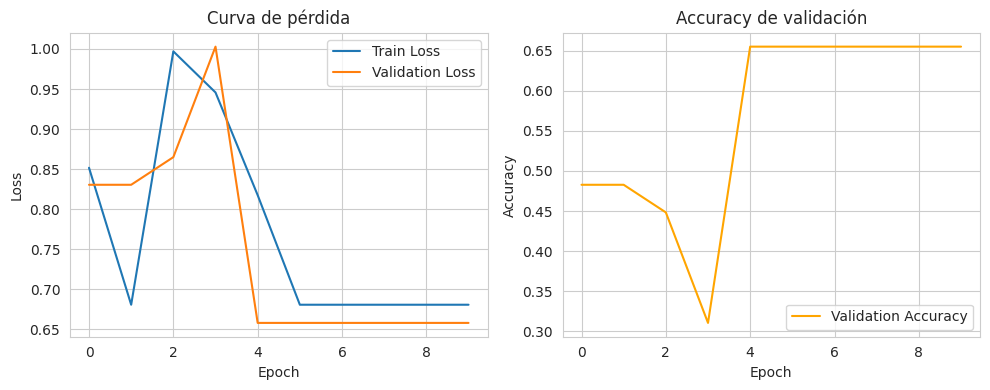

In [ ]:

# --- restore best model
model.load_state_dict(best_state)
print(f"\n✅ Best Validation Accuracy: {best_acc:.4f} at Val Loss {best_val_loss:.4f}")

# --- plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Curva de pérdida")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accs, label='Validation Accuracy', color='orange')
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Accuracy de validación")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
unique, counts = torch.unique(labels_full[labels_full != -1], return_counts=True)
print(dict(zip(unique.tolist(), counts.tolist())))

# print as percentage
total_labeled = counts.sum().item()
print({k: f"{(v / total_labeled * 100):.2f}%" for k, v in zip(unique.tolist(), counts.tolist())})

{0: 93, 1: 53}
{0: '63.70%', 1: '36.30%'}


El modelo R-GCN alcanzó un accuracy de validación cercano a 0.65, aunque la forma en que llega a ese valor es particular: las curvas de pérdida muestran oscilaciones fuertes al inicio y luego una caída abrupta, mientras la accuracy se estabiliza de la misma forma. Esto sugiere que el modelo logra capturar algún patrón útil, pero sobre un conjunto de entrenamiento extremadamente reducido.

De los 18.002 nodos de la clase Lexicon/NamedRockUnit, solo 146 tienen etiquetas, lo que representa una señal supervisada muy escasa. Además, esos nodos probablemente se concentran en zonas específicas del grafo, lo que limita la capacidad del modelo de propagar información de manera efectiva --recordemos que la R-GCN se basa en sus convoluciones para mover información entre vecinos, más lejos según más capas convolucionales hayan. La R-GCN termina aprendiendo sobre muy pocos ejemplos, y el resultado parece reflejar un ajuste local más que un aprendizaje generalizable. La estabilización rápida de la accuracy y el early stopping temprano refuerzan esta idea: el modelo deja de mejorar porque no tiene suficiente variabilidad de ejemplos para seguir aprendiendo.

Los experimentos de hiperparámetros muestran resultados similares (entre 0.6 y 0.7 de accuracy) independientemente de la cantidad de capas o del tamaño de los embeddings, lo que indica que el cuello de botella está en los datos, no en la arquitectura. El mejor desempeño con L=0 sugiere que la estructura del grafo no está aportando mucho, y que el modelo se apoya principalmente en señales locales o atributos básicos.

En resumen, el resultado de 0.65 es incluso bastante bueno dadas las limitaciones del dataset: el modelo aprende ciertos patrones locales pero no logra generalizar. Para mejorar el rendimiento sería necesario aumentar el número de nodos etiquetados, usar técnicas de propagación de etiquetas (*label propagation*) para etiquetar otros nodos de forma automática en base a sus conexiones con otros nodos etiquetados, o pseudo-etiquetado (*pseudo-labeling*), que incorpora nuevas etiquetas generadas por el propio modelo y las asume como “ciertas” en iteraciones posteriores. En otras palabras, una forma de aprendizaje no supervisado inicializado con un esquema supervisado.

# Parte 2: Graph Transformer (20 puntos)

En esta segunda sección se debe trabajar con el conjunto de datos **caco2_wang**, contenido en el benchmark de ADMET.

**Observación**

Para cargar el dataset debe seguir el procedimiento visto en clases (8 - Graph-transformer)

## 2.1 Conceptos básicos (5 puntos)

Responda las siguientes preguntas:

1. En el contexto de Graph Transformers, defina el concepto de **sparseness**. ¿Qué implicancias tiene este concepto en las capacidades de cómputo requeridas para trabajar con dichas arquitecturas?

2. Explique el concepto de **positional encoding** en el contexto de los Graph Transformers y compare su formulación con la empleada en el Transformer original (Vaswani et al., 2017).

**Observación**

Se recomienda revisar la publicación **Attention Is All You Need** (Vaswani et al., 2017). Disponible en: https://papers.neurips.cc/paper/7181-attention-is-all-you-need.pdf

Respuesta:

1.

A modo general, **graph sparsity** hace referencia cuán cerca (o lejos) está un grafo de ser completo. De forma más matemática, puede representarse como la razón entre la cantidad de aristas presentes y la cantidad de aristas posibles, dada la cantidad de nodos. Mientras más baja la razón (menos aristas reales vs posibles), más *sparse*. Esto tiene relevancia en como se traduce la arquitectura de transformers desde NLP a GML.

En la arquitectura tradicional de transformers, en NLP, se trata a la oración como un grafo completo: El mecanismo de atención considera a todo el resto de tokens (incluyéndose a sí mismo) como elementos con los cuales el token objetivo tiene relación. Esto se debe principalmente a que las oraciones no tienen definiciones evidentes y objetivos de interacciones entre tokens -- más allá del token anterior y siguiente en la oración -- pero es claro que el lenguaje se construye en base a relaciones entre palabras no necesariamente contiguas. El problema es que estas relaciones son complejas, y dependen fuertemente del contexto. Por esto el transformer es una arquitectura tan poderosa, porque le otorga al modelo la capacidad de poder modular la "atención" que cada token le entrega al resto, partiendo desde una secuencia completamente conectada.

En GML, la situación es distinta. Los grafos **si** tienen relaciones objetivamente establecidas, denotadas por aristas entre nodos. Los grafos reales son *sparse*: Solamente una pequeña fracción de las aristas posibles está efectivamente presente en el grafo. Los grafos *fully-connected* son muy raros en la práctica. No es necesario modelar el mecanismo de atención global de la misma manera que en NLP, precisamente porque las relaciones son explícitas.

Esto también aborda la situación de capacidad de cómputo: Una oración es un grafo completo pequeño, usualmente con cientos de tokens (nodos). Un dataset de grafos puede perfectamente superar el millón de nodos. Tratar estos grafos de forma completa y utilizar atención global en ellos es infactible computacionalmente. Usar atención específica al vecindario de cada nodo es, en constraste, una alternativa más ligera por varios órdenes de magnitud.

Referencia:
- A Generalization of Transformer Networks to Graphs (https://arxiv.org/pdf/2012.09699)

2.

En el Transformer original, las positional encodings sinusoidales incorporan información de orden en la secuencia mediante funciones seno y coseno de distintas frecuencias. Cada dimensión del embedding corresponde a una frecuencia diferente, y la posición se codifica en la fase de estas ondas. De este modo, las diferencias entre codificaciones reflejan la distancia relativa entre tokens, permitiendo que el modelo reconozca relaciones espaciales sin depender de un orden explícito.

En los Graph Transformers, la idea se extiende al dominio de grafos, donde no hay un orden lineal sino una estructura de conectividad. Para ello se utilizan los Laplacian Positional Encodings (LPE), construidos a partir de la descomposición espectral del laplaciano del grafo, *L = UΔUᵀ*, donde las columnas de *U = [u_1, ..., u_n]* son los eigenvectores y *Δ* contiene los eigenvalores.

Cada eigenvector uₖ (se toman los primeros k en Graph Transformers) del laplaciano asigna un valor a cada nodo, describiendo su posición relativa dentro del grafo en términos de “frecuencias estructurales”. Los de eigenvalores pequeños reflejan relaciones globales y los grandes, variaciones locales. Esto ocurre porque el laplaciano mide diferencias entre nodos conectados, y sus autovectores representan los patrones más fundamentales de esa estructura. Así, al usar las primeras componentes de *U* como positional encodings, el modelo obtiene una noción de proximidad y estructura global.

Finalmente, cuando el grafo es una línea, los autovectores del laplaciano corresponden exactamente a ondas sinusoidales, lo que muestra que las codificaciones del Transformer original son un caso particular unidimensional de los Laplacian Positional Encodings. Ambos métodos comparten el mismo principio: representar posiciones relativas mediante “modos de variación” sobre una estructura, ya sea lineal o arbitraria.

Referencias:
- Attention Is All You Need (https://proceedings.neurips.cc/paper_files/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf)
- A Generalization of Transformer Networks to Graphs (https://arxiv.org/pdf/2012.09699)
- Laplacian Eigenmaps for Dimensionality Reduction and Data Representation (https://www2.imm.dtu.dk/projects/manifold/Papers/Laplacian.pdf)

## 2.2 Implementación Graph Transformer (15 puntos)

Proponga cuatro modelos para la tarea de regresión asociada al dataset **caco2_wang**, utilizando la arquitectura **Graph Transformer**. Para ello, haga modificaciones tanto en el número de cabezales como en el número de capas. Justifique sus decisiones.

Compare sus resultados con el Leaderboard disponible en: https://tdcommons.ai/benchmark/admet_group/01caco2/

**Observación**

* Defina el número de épocas de manera que se garantice la convergencia del entrenamiento.
* Trabaje con los conjuntos ya definidos de train, val y test.

Respuesta:

Primero, cargamos el dataset usando el helper de gt_pyg para tdc

In [ ]:
PE_DIM = 6
(tr, va, te) = get_train_valid_test_data('caco2_wang', min_num_atoms=0)
tr_dataset = get_tensor_data(tr.Drug.to_list(), tr.Y.to_list(), pe_dim=PE_DIM)
va_dataset = get_tensor_data(va.Drug.to_list(), va.Y.to_list(), pe_dim=PE_DIM)
te_dataset = get_tensor_data(te.Drug.to_list(), te.Y.to_list(), pe_dim=PE_DIM)
NODE_DIM = get_node_dim()
EDGE_DIM = get_edge_dim()

print(f'Number of training examples: {len(tr_dataset)}')
print(f'Number of validation examples: {len(va_dataset)}')
print(f'Number of test examples: {len(te_dataset)}')

train_loader = DataLoader(tr_dataset, batch_size=64)
val_loader = DataLoader(va_dataset, batch_size=512)
test_loader = DataLoader(te_dataset, batch_size=512)

Found local copy...
Loading...


Done!
Processing data: 637it [00:08, 76.62it/s] 
Processing data: 91it [00:00, 115.46it/s]
Processing data: 182it [00:01, 100.64it/s]
Processing data: 1it [00:00, 450.76it/s]
Processing data: 1it [00:00, 485.40it/s]

Number of training examples: 637
Number of validation examples: 91
Number of test examples: 182


In [ ]:
print(f'Node dim: {NODE_DIM}')
print(f'Edge dim: {EDGE_DIM}')

Node dim: 76
Edge dim: 10


Extendemos la clase GraphTransformerNet directamente para incluir métodos de train y test

In [ ]:
class GTModel(GraphTransformerNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        self.scheduler = ReduceLROnPlateau(self.optimizer, mode='min', factor=0.5, patience=10, min_lr=1e-5)

    def train_one_epoch(self, train_loader, loss_func):
        self.train()
        train_mae = MeanAbsoluteError().to(device)

        for data in train_loader:
            data = data.to(device)
            self.optimizer.zero_grad()

            # positional encoding flip
            batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM), device=device).float() - 1.0)
            out, _ = self(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch, zero_var=False)
            loss = loss_func(out.squeeze(), data.y)
            loss.backward()
            self.optimizer.step()

            train_mae.update(out.squeeze(), data.y)

        return train_mae.compute()

    @torch.no_grad()
    def test(self, loader):
        self.eval()
        test_mae = MeanAbsoluteError().to(device)

        for data in loader:
            data = data.to(device)
            batch_pe = data.pe * (2 * torch.randint(low=0, high=2, size=(1, PE_DIM), device=device).float() - 1.0)
            out, _ = self(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)
            test_mae.update(out.squeeze(), data.y)

        return test_mae.compute()

    def train_and_test_loop(self, epochs, loss_func, train_loader, val_loader, test_loader, patience=30):
        best_val = np.inf
        best_test = np.inf
        best_epoch = 0
        wait = 0
        best_state = None

        for epoch in range(1, epochs + 1):
            tr_loss = self.train_one_epoch(train_loader, loss_func)
            va_loss = self.test(val_loader)
            te_loss = self.test(test_loader)
            self.scheduler.step(va_loss)

            if va_loss < best_val - 1e-4:
                best_val, best_test, best_epoch = va_loss, te_loss, epoch
                wait = 0
                best_state = {k: v.cpu() for k, v in self.state_dict().items()}
            else:
                wait += 1
                if wait >= patience:
                    print(f"\n⏹️ Early stopping at epoch {epoch} (no val improvement for {patience} epochs).")
                    break

            if epoch % 10 == 0 or epoch == 1:
                print(f"Epoch {epoch:03d} | Train: {tr_loss:.4f} | Val: {va_loss:.4f} | Test: {te_loss:.4f}")

        if best_state:
            self.load_state_dict(best_state)
            print(f"\n✅ Restored best model from epoch {best_epoch} | Val: {best_val:.4f} | Test: {best_test:.4f}")

        return best_epoch, best_val, best_test


### Prueba de hiperparámetros:

Ahora, haremos una ablación de hiperparámetros para probar variaciones sobre número de capas Graph Transformer y el número de cabezales de atención que incluye cada una de estas capas:
- num_gt_layers -> [2, 3, 4, 5, 6]
- num_heads -> [1, 2, 4, 8, 16]

Viendo como se comportan los mejores parámetros de estas selecciones, probaremos combinaciones con ellos para encontrar las mejores combinaciones de estos parámetros.

Adicionalmente, haremos variaciones sobre otros parámetros. Estos no se probarán en combinaciones, sino que los que entreguen mejores combinaciones serán utilizados en las combinaciones finales. Estos parámetros son:
- hidden_dim: El número de dimensiones de las capas ocultas -> [64, 128, 256]
- dropout: Probabilidad de dropout (eliminación/zeroing de pesos en la red) -> [0.0, 0.1, 0.3]
- act: El tipo de función de activación -> ["relu", "gelu", "silu"]

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [ ]:
def run_sweep(param_names, values, defaults, max_epochs=30, seed=42, save_csv=True):
    """
    Run hyperparameter sweeps for one or more parameters.
    - param_names: str or list of str
    - values: list of values (for one param) or list of tuples (for combinations)
    """
    results = []
    if isinstance(param_names, str):
        param_names = [param_names]

    print(f"\n=== Starting sweep for {param_names} ===")

    for combo in values:
        if not isinstance(combo, (list, tuple)):
            combo = [combo]

        set_seed(seed)
        config = defaults.copy()
        label_parts = []

        # assign each parameter its value
        for p, v in zip(param_names, combo):
            config[p] = v
            label_parts.append(f"{p}={v}")
        label = "_".join(label_parts)

        print(f"\n--- Testing {label} ---")
        model = GTModel(**config).to(device)
        loss_func = nn.L1Loss()

        best_epoch, val_mae, test_mae = model.train_and_test_loop(
            max_epochs, loss_func,
            train_loader, val_loader, test_loader
        )

        results.append({
            "config": label,
            **{p: v for p, v in zip(param_names, combo)},
            "val_mae": val_mae.item(),
            "test_mae": test_mae.item(),
            "best_epoch": best_epoch
        })

        print(f"→ {label}: Val MAE={val_mae:.4f}, Test MAE={test_mae:.4f}")

    df = pd.DataFrame(results)

    if save_csv:
        name = "_".join(param_names)
        csv_name = f"sweep_{name}.csv"
        df.to_csv(csv_name, index=False)
        print(f"Saved results to {csv_name}")

    # --- Plot ---
    plt.figure(figsize=(7,4))
    sns.barplot(x="config", y="val_mae", data=df, palette="Blues_d")
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Efecto de {' & '.join(param_names)} sobre MAE en validación")
    plt.xlabel("Configuración")
    plt.ylabel("MAE validación")
    plt.tight_layout()
    plt.show()

    return df


defaults = dict(
    node_dim_in=NODE_DIM,
    edge_dim_in=EDGE_DIM,
    pe_in_dim=PE_DIM,
    num_gt_layers=4,
    hidden_dim=128,
    num_heads=8,
    norm='bn',
    gate=False,
    qkv_bias=False,
    gt_aggregators=['sum'],
    aggregators=['sum'],
    dropout=0.1,
    act='relu'
)


Primero, probamos de forma individual los distintos números de capas.


=== Testing num_gt_layers = 2 ===
Epoch 001 | Train: 3.1873 | Val: 3.9954 | Test: 4.1386
Epoch 010 | Train: 1.2832 | Val: 2.7700 | Test: 2.9006
Epoch 020 | Train: 1.0476 | Val: 2.7324 | Test: 2.8793
Epoch 030 | Train: 0.9360 | Val: 2.7550 | Test: 2.8171
Epoch 040 | Train: 0.6841 | Val: 1.0474 | Test: 1.0035
Epoch 050 | Train: 0.6371 | Val: 1.3352 | Test: 1.2571
Epoch 060 | Train: 0.5494 | Val: 1.0729 | Test: 1.0598
Epoch 070 | Train: 0.5474 | Val: 0.9716 | Test: 0.9469

⏹️ Early stopping at epoch 71 (no val improvement for 30 epochs).

✅ Restored best model from epoch 41 | Val: 0.5928 | Test: 0.5708
→ num_gt_layers=2: Val MAE=0.5928, Test MAE=0.5708

=== Testing num_gt_layers = 3 ===
Epoch 001 | Train: 3.6128 | Val: 3.3125 | Test: 3.2327
Epoch 010 | Train: 1.0592 | Val: 1.3883 | Test: 1.3563
Epoch 020 | Train: 1.1386 | Val: 1.2121 | Test: 1.2896
Epoch 030 | Train: 0.8632 | Val: 0.9591 | Test: 0.9604
Epoch 040 | Train: 0.7286 | Val: 1.0105 | Test: 1.0440
Epoch 050 | Train: 0.6277 | Val

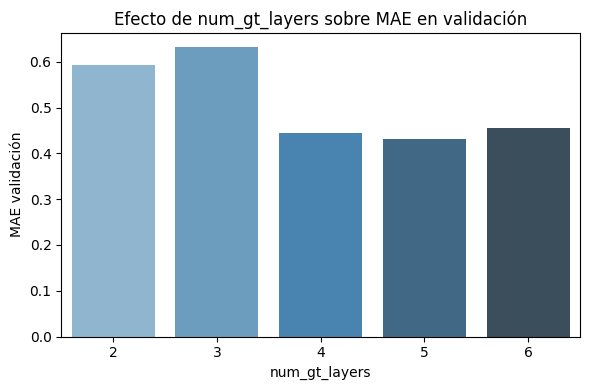

In [ ]:
df_layers = run_sweep("num_gt_layers", [2, 3, 4, 5, 6], defaults, max_epochs=100)

De estos resultados, podemos observar que utilizando desde 4 a 6 capas, el error absoluto medio de validación se mantienen bastante bajo, con muy poca diferencia entre ellos. Utilizaremos estos en las combinaciones.

Ahora, probamos el número de cabezales de atención. El modelo tiene el requisito implícito de requerir que el número de dimensiones ocultas (hidden_dim, 128 por defecto) sea divisible entre el número de cabezales. Esto deja las opciones [1, 2, 4, 8, 16].


=== Starting sweep for ['num_heads'] ===

--- Testing num_heads=1 ---
Epoch 001 | Train: 2.9259 | Val: 2.2852 | Test: 2.4674
Epoch 010 | Train: 1.3351 | Val: 5.8084 | Test: 5.5756
Epoch 020 | Train: 0.9339 | Val: 1.2768 | Test: 1.3066
Epoch 030 | Train: 0.8549 | Val: 0.8305 | Test: 0.8232
Epoch 040 | Train: 0.7144 | Val: 1.1854 | Test: 1.0555
Epoch 050 | Train: 0.5413 | Val: 0.6317 | Test: 0.7078
Epoch 060 | Train: 0.5213 | Val: 0.6457 | Test: 0.6287
Epoch 070 | Train: 0.4572 | Val: 0.4924 | Test: 0.5893
Epoch 080 | Train: 0.3889 | Val: 0.4686 | Test: 0.4971
Epoch 090 | Train: 0.3824 | Val: 0.5812 | Test: 0.6138

⏹️ Early stopping at epoch 93 (no val improvement for 30 epochs).

✅ Restored best model from epoch 63 | Val: 0.4570 | Test: 0.5338
→ num_heads=1: Val MAE=0.4570, Test MAE=0.5338

--- Testing num_heads=2 ---
Epoch 001 | Train: 2.9524 | Val: 15.3402 | Test: 15.6242
Epoch 010 | Train: 1.1583 | Val: 4.2949 | Test: 4.4664
Epoch 020 | Train: 1.0504 | Val: 2.0379 | Test: 1.9733
Epo

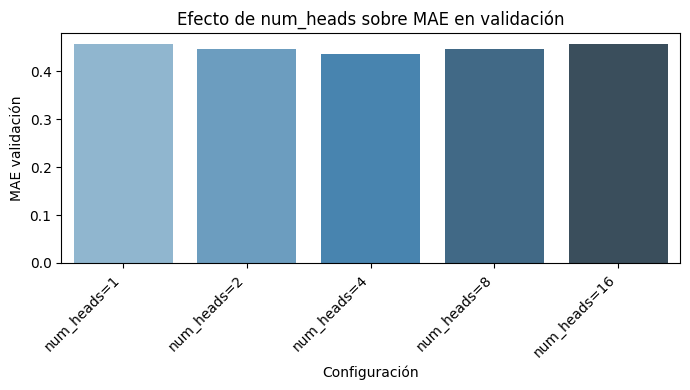

In [ ]:
df_heads = run_sweep("num_heads", [1, 2, 4, 8, 16], defaults, max_epochs=100)

Podemos ver que la diferencia en error absoluto medio para los distintos valores de num_heads es muy pequeña, con una leve tendencia hacia un óptimo alrededor de 4 cabezales de atención. Llevaremos los 2 mejores valores, 4 y 8, para la validación. Adicionalmente llevaremos el valor 16, solo con el fin de exponer y tener una referencia de un modelo con un mayor número de parámetros.

Ahora, haremos las pruebas con el resto de hiperparámetros, y veremos cuales se seleccionarán para los modelos finales. Primero con hidden_dim.


=== Testing hidden_dim = 64 ===
Epoch 001 | Train: 2.9184 | Val: 2.9743 | Test: 3.0330
Epoch 010 | Train: 1.1407 | Val: 1.3949 | Test: 1.3377
Epoch 020 | Train: 0.9702 | Val: 1.5005 | Test: 1.5046
Epoch 030 | Train: 0.8732 | Val: 1.7094 | Test: 1.6871
Epoch 040 | Train: 0.7540 | Val: 1.4825 | Test: 1.3621
Epoch 050 | Train: 0.6530 | Val: 0.7617 | Test: 0.7321
Epoch 060 | Train: 0.6041 | Val: 0.6419 | Test: 0.6301
Epoch 070 | Train: 0.5730 | Val: 0.7668 | Test: 0.7361
Epoch 080 | Train: 0.5755 | Val: 0.6263 | Test: 0.6266
Epoch 090 | Train: 0.5498 | Val: 0.9388 | Test: 0.9210
Epoch 100 | Train: 0.5334 | Val: 0.6278 | Test: 0.6152

✅ Restored best model from epoch 99 | Val: 0.5336 | Test: 0.5101
→ hidden_dim=64: Val MAE=0.5336, Test MAE=0.5101

=== Testing hidden_dim = 128 ===
Epoch 001 | Train: 2.9710 | Val: 11.9073 | Test: 12.3324
Epoch 010 | Train: 1.1414 | Val: 1.8456 | Test: 1.8323
Epoch 020 | Train: 1.0452 | Val: 1.2205 | Test: 1.2441
Epoch 030 | Train: 0.8301 | Val: 1.4606 | Test

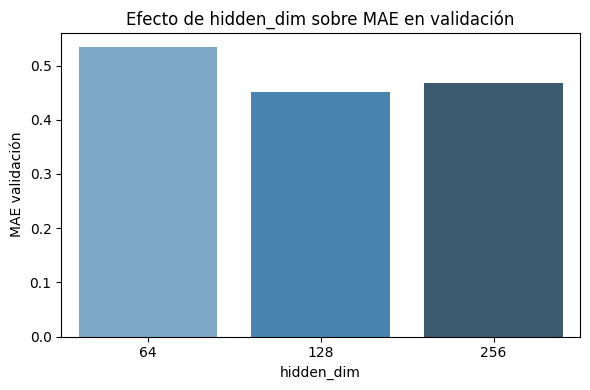

In [ ]:
df_hidden = run_sweep("hidden_dim", [64, 128, 256], defaults, max_epochs=100)

Es evidente que la mejor opción para hidden_dim, al menos con el resto de parámetros en su estado "base", es 128. 256 se acerca, pero la introducción de más parámetros siempre lleva el riesgo de overfitting, por lo que usaremos únicamente 128.

Ahora, con distintos valores de dropout.


=== Testing dropout = 0.0 ===
Epoch 001 | Train: 2.8480 | Val: 1.8697 | Test: 1.7572
Epoch 010 | Train: 1.1437 | Val: 7.2501 | Test: 7.2357
Epoch 020 | Train: 1.1548 | Val: 3.7690 | Test: 3.5548
Epoch 030 | Train: 0.6445 | Val: 2.5958 | Test: 2.3871
Epoch 040 | Train: 0.4156 | Val: 0.7460 | Test: 0.8217
Epoch 050 | Train: 0.3701 | Val: 0.5429 | Test: 0.5636
Epoch 060 | Train: 0.2677 | Val: 1.0656 | Test: 0.9713
Epoch 070 | Train: 0.1878 | Val: 0.4711 | Test: 0.5322
Epoch 080 | Train: 0.1633 | Val: 0.4412 | Test: 0.4976
Epoch 090 | Train: 0.1544 | Val: 0.4668 | Test: 0.5257
Epoch 100 | Train: 0.1387 | Val: 0.4425 | Test: 0.4790

✅ Restored best model from epoch 92 | Val: 0.4407 | Test: 0.4970
→ dropout=0.0: Val MAE=0.4407, Test MAE=0.4970

=== Testing dropout = 0.1 ===
Epoch 001 | Train: 2.9601 | Val: 14.9801 | Test: 15.4085
Epoch 010 | Train: 1.0895 | Val: 1.0304 | Test: 0.9703
Epoch 020 | Train: 1.0353 | Val: 1.7265 | Test: 1.6636
Epoch 030 | Train: 0.8863 | Val: 1.1539 | Test: 1.070

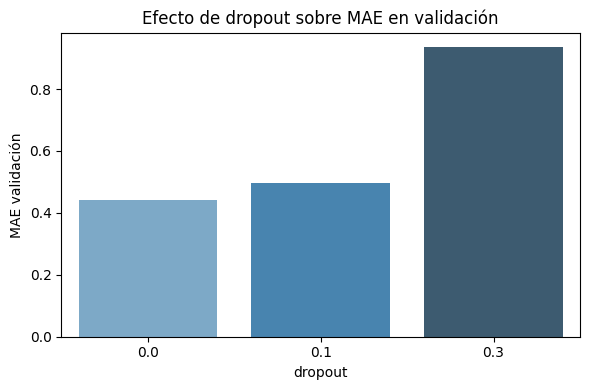

In [ ]:
df_dropout = run_sweep("dropout", [0.0, 0.1, 0.3], defaults, max_epochs=100)

Curiosamente, vemos que el modelo sin dropout tiene el mejor rendimiento en validación. Incluso al modificar solo un poco el dropout, a 0.1, ya se nota un aumento en el error. Probaremos tanto 0.0 como 0.1 en las combinaciones.

Finalmente, probando distintas funciones de activación.


=== Starting sweep for ['act'] ===

--- Testing act=relu ---
Epoch 001 | Train: 2.9870 | Val: 11.6007 | Test: 11.9022
Epoch 010 | Train: 1.0649 | Val: 3.9923 | Test: 3.9340
Epoch 020 | Train: 0.9736 | Val: 1.0735 | Test: 1.1798
Epoch 030 | Train: 0.9792 | Val: 1.5192 | Test: 1.6466
Epoch 040 | Train: 0.8204 | Val: 1.7692 | Test: 1.7796
Epoch 050 | Train: 0.5826 | Val: 0.6488 | Test: 0.7041
Epoch 060 | Train: 0.5167 | Val: 0.5288 | Test: 0.6035
Epoch 070 | Train: 0.5200 | Val: 0.6112 | Test: 0.6313
Epoch 080 | Train: 0.4463 | Val: 0.4720 | Test: 0.5537
Epoch 090 | Train: 0.4220 | Val: 0.6267 | Test: 0.6123
Epoch 100 | Train: 0.3484 | Val: 0.4321 | Test: 0.4593

✅ Restored best model from epoch 98 | Val: 0.4033 | Test: 0.4699
→ act=relu: Val MAE=0.4033, Test MAE=0.4699

--- Testing act=gelu ---
Epoch 001 | Train: 2.9377 | Val: 10.9716 | Test: 11.3066
Epoch 010 | Train: 1.1110 | Val: 0.9938 | Test: 1.2143
Epoch 020 | Train: 0.9062 | Val: 1.4971 | Test: 1.4579
Epoch 030 | Train: 0.7291 | 

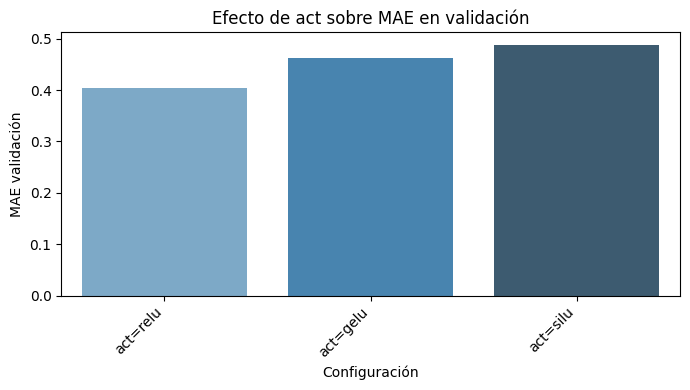

In [ ]:
df_act = run_sweep("act", ["relu", "gelu", "silu"], defaults, max_epochs=100)


En este caso, utilizar la función sencilla ReLU tuvo los mejores resultados, con una clara diferencia. Es probable que el corte a 0 que hace ReLU (a diferencia de GELU, que introduce un suavizado para mejorar el cálculo de gradiente), ayude al modelo a generalizar mejor y evitar sobreajuste. Utilizaremos únicamente ReLU en los modelos finales.

### Combinaciones de parámetros

Ejecutaremos una vez más las pruebas, ahora combinando los mejores parámetros de n_gt_layers y num_heads. Haremos múltiples pasadas sobre distintas inicializaciones (seeds), para mostrar el rendimiento promedio y la varianza a través de ellas, para evaluar de forma más consistente:

In [ ]:
def run_sweep_multiseed(param_names, values, defaults, max_epochs=100, seeds=[42, 1337, 2024], save_csv=True):
    """
    Run hyperparameter sweeps (supports multiple parameters) averaged over multiple random seeds.
    Displays mean ± std of Validation MAE.
    """
    if isinstance(param_names, str):
        param_names = [param_names]

    print(f"\n=== Multi-seed sweep for {param_names} ===")
    all_results = []

    for combo in values:
        if not isinstance(combo, (list, tuple)):
            combo = [combo]

        label_parts = [f"{p}={v}" for p, v in zip(param_names, combo)]
        label = "_".join(label_parts)
        print(f"\n--- Testing {label} ---")

        seed_records = []

        for seed in seeds:
            set_seed(seed)
            config = defaults.copy()
            for p, v in zip(param_names, combo):
                config[p] = v

            model = GTModel(**config).to(device)
            loss_func = nn.L1Loss()

            best_epoch, val_mae, test_mae = model.train_and_test_loop(
                max_epochs, loss_func,
                train_loader, val_loader, test_loader
            )

            seed_records.append({
                "seed": seed,
                "config": label,
                **{p: v for p, v in zip(param_names, combo)},
                "val_mae": val_mae.item(),
                "test_mae": test_mae.item(),
                "best_epoch": best_epoch
            })
            print(f"   Seed {seed}: Val MAE={val_mae:.4f}, Test MAE={test_mae:.4f}")

        df_seed = pd.DataFrame(seed_records)
        val_mean = df_seed["val_mae"].mean()
        val_std = df_seed["val_mae"].std()
        test_mean = df_seed["test_mae"].mean()
        test_std = df_seed["test_mae"].std()

        all_results.append({
            "config": label,
            **{p: v for p, v in zip(param_names, combo)},
            "val_mae_mean": val_mean,
            "val_mae_std": val_std,
            "test_mae_mean": test_mean,
            "test_mae_std": test_std
        })

        print(f"→ {label}: Val MAE={val_mean:.4f}±{val_std:.4f}, Test MAE={test_mean:.4f}±{test_std:.4f}")

    df = pd.DataFrame(all_results)

    if save_csv:
        name = "_".join(param_names)
        csv_name = f"sweep_multiseed_{name}.csv"
        df.to_csv(csv_name, index=False)
        print(f"Saved results to {csv_name}")

    # --- Plot mean ± std ---
    plt.figure(figsize=(8,5))
    sns.barplot(x="config", y="val_mae_mean", data=df, palette="Blues_d")
    plt.errorbar(
        x=range(len(df)),
        y=df["val_mae_mean"],
        yerr=df["val_mae_std"],
        fmt="none",
        ecolor="black",
        capsize=4,
        elinewidth=1,
    )
    plt.xticks(rotation=45, ha='right')
    plt.title(f"Efecto de {' & '.join(param_names)} sobre MAE en validación (media ± std)")
    plt.xlabel("Configuración")
    plt.ylabel("MAE validación")
    plt.tight_layout()
    plt.show()

    return df


=== Multi-seed sweep for ['num_gt_layers', 'num_heads'] ===

--- Testing num_gt_layers=3_num_heads=4 ---
Epoch 001 | Train: 3.7936 | Val: 2.6147 | Test: 2.7031
Epoch 010 | Train: 1.1634 | Val: 2.3384 | Test: 2.1399
Epoch 020 | Train: 1.2832 | Val: 1.2306 | Test: 1.2243
Epoch 030 | Train: 0.7273 | Val: 0.9343 | Test: 1.0429
Epoch 040 | Train: 0.7141 | Val: 1.2093 | Test: 1.2949
Epoch 050 | Train: 0.6091 | Val: 0.9386 | Test: 0.9840
Epoch 060 | Train: 0.6048 | Val: 0.8722 | Test: 0.9022
Epoch 070 | Train: 0.5987 | Val: 0.8243 | Test: 0.8118
Epoch 080 | Train: 0.5587 | Val: 0.8529 | Test: 0.8568

⏹️ Early stopping at epoch 83 (no val improvement for 30 epochs).

✅ Restored best model from epoch 53 | Val: 0.7190 | Test: 0.7720
   Seed 42: Val MAE=0.7190, Test MAE=0.7720
Epoch 001 | Train: 2.8478 | Val: 16.0394 | Test: 16.4542
Epoch 010 | Train: 1.1433 | Val: 3.4421 | Test: 3.5372
Epoch 020 | Train: 0.8211 | Val: 1.0003 | Test: 1.0560
Epoch 030 | Train: 0.8684 | Val: 1.2629 | Test: 1.1706


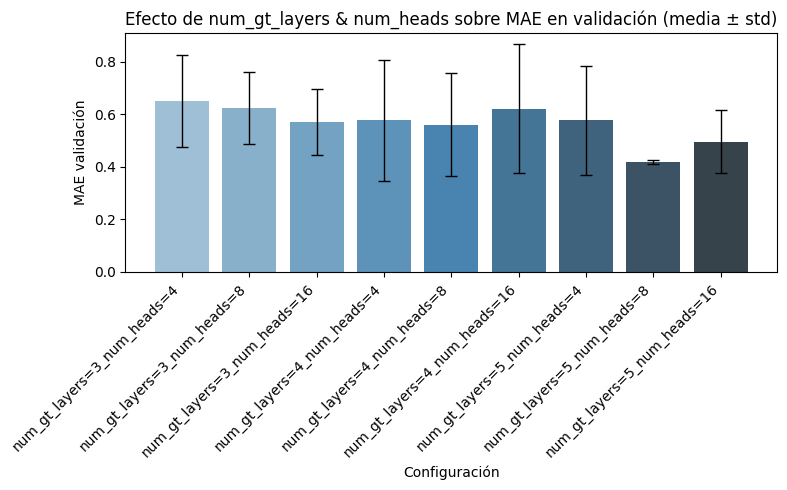

In [ ]:
comb_params = list(product([3, 4, 5], [4, 8, 16]))
df_comb = run_sweep_multiseed(["num_gt_layers", "num_heads"], comb_params, defaults, max_epochs=100)

Hemos probado las combinaciones, pero vemos que tenemos un problema de varianza. Los modelos no están siendo estables, ya que las distintas inicializaciones están influyendo fuertemente en el MAE alcanzado. Estos resultados no nos permiten ver con claridad cuales son las combinaciones que mejor rindieron en el entrenamiento. Vamos a ajustar el modelo GTModel para intentar reducir esto
- Mayor patience antes de early stopping: Desde los logs de entrenamiento, algunos modelos se detuvieron bastante antes que otros, y en puntos de MAE de validación menores. Incrementar el patience a 50 epochs le da una mejor oportunidad al modelo de salir de mínimos locales.
- Menor Learning Rate: Valores altos introducen ruido al gradiente, lo cuál mejora la exploración inicial pero causa inestabilidad y convergencia poco predecible. Saltos más pequeños en el gradiente hacen el entrenamiento menos caótico y más estable entre seeds.
- Weight Decay en optimizer: Penaliza variaciones en los parámetros, de forma proporcional al tamaño del update del parámetro, efectivamente evitando grandes variaciones. De esta forma, la optimización llega a mínimos más planos, menos sensibles a perturbaciones ligeras. Esto también estabiliza el entrenamiento entre seeds.
- Clipping de gradiente: Opera de forma similar al weight decay, pero limitando el cálculo de gradiente una vez superado un umbral, no directamente sobre el optimizador y los pesos. Si se activa (en un salto grande de gradiente), esta señal es reducida, y el gradiente propagado hacia los pesos se reduce de forma general (esto a diferencia de weight decay, que opera en la modificación de cada peso directamente).

Adicionalmente, algunos de estos cambios actúan como regularizadores del modelo, previniendo el overfitting. Con esto, nos permitimos también aumentar el número de epochs de entrenamiento a 400.

Referencias:
- Sobre tamaño de Learning Rates: A Bayesian Perspective on Generalization and Stochastic Gradient Descent (https://arxiv.org/pdf/1710.06451)
- Sobre Weight Decay: Decoupled Weight Decay Regularization (https://arxiv.org/pdf/1711.05101)
- Sobre Gradient Clipping: On the difficulty of training Recurrent Neural Networks (https://arxiv.org/pdf/1211.5063)

In [ ]:
class GTModel(GraphTransformerNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.optimizer = torch.optim.Adam(
            self.parameters(),
            lr=3e-4,
            weight_decay=1e-5
        )
        self.scheduler = ReduceLROnPlateau(
            self.optimizer, mode='min', factor=0.5,
            patience=15, min_lr=1e-5
        )

    def train_one_epoch(self, train_loader, loss_func):
        self.train()
        train_mae = MeanAbsoluteError().to(device)

        for data in train_loader:
            data = data.to(device)
            self.optimizer.zero_grad()

            batch_pe = data.pe * (
                2 * torch.randint(low=0, high=2, size=(1, PE_DIM), device=device).float() - 1.0
            )
            out, _ = self(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch, zero_var=False)
            loss = loss_func(out.squeeze(), data.y)
            loss.backward()

            torch.nn.utils.clip_grad_norm_(self.parameters(), max_norm=1.0)

            self.optimizer.step()
            train_mae.update(out.squeeze(), data.y)

        return train_mae.compute()

    @torch.no_grad()
    def test(self, loader):
        self.eval()
        test_mae = MeanAbsoluteError().to(device)
        for data in loader:
            data = data.to(device)
            batch_pe = data.pe * (
                2 * torch.randint(low=0, high=2, size=(1, PE_DIM), device=device).float() - 1.0
            )
            out, _ = self(data.x, data.edge_index, data.edge_attr, batch_pe, data.batch)
            test_mae.update(out.squeeze(), data.y)
        return test_mae.compute()

    def train_and_test_loop(
        self, epochs, loss_func, train_loader, val_loader, test_loader, patience=50
    ):
        best_val = np.inf
        best_test = np.inf
        best_epoch = 0
        wait = 0
        best_state = None

        for epoch in range(1, epochs + 1):
            tr_loss = self.train_one_epoch(train_loader, loss_func)
            va_loss = self.test(val_loader)
            te_loss = self.test(test_loader)
            self.scheduler.step(va_loss)

            if va_loss < best_val - 1e-4:
                best_val, best_test, best_epoch = va_loss, te_loss, epoch
                wait = 0
                best_state = {k: v.cpu() for k, v in self.state_dict().items()}
            else:
                wait += 1
                if wait >= patience:
                    print(f"\n⏹️ Early stopping at epoch {epoch} (no val improvement for {patience} epochs).")
                    break

            if epoch % 10 == 0 or epoch == 1:
                print(f"Epoch {epoch:03d} | Train: {tr_loss:.4f} | Val: {va_loss:.4f} | Test: {te_loss:.4f}")

        if best_state:
            self.load_state_dict(best_state)
            print(f"\n✅ Restored best model from epoch {best_epoch} | Val: {best_val:.4f} | Test: {best_test:.4f}")

        return best_epoch, best_val, best_test



=== Multi-seed sweep for ['num_gt_layers', 'num_heads'] ===

--- Testing num_gt_layers=3_num_heads=4 ---
Epoch 001 | Train: 3.8788 | Val: 4.1151 | Test: 4.1937
Epoch 010 | Train: 1.2406 | Val: 1.9038 | Test: 1.9385
Epoch 020 | Train: 0.9887 | Val: 2.4601 | Test: 2.4695
Epoch 030 | Train: 0.7755 | Val: 2.0025 | Test: 2.0010
Epoch 040 | Train: 0.7539 | Val: 1.4260 | Test: 1.4651
Epoch 050 | Train: 0.6267 | Val: 0.9630 | Test: 0.9408
Epoch 060 | Train: 0.6183 | Val: 0.7745 | Test: 0.8148
Epoch 070 | Train: 0.5780 | Val: 0.7199 | Test: 0.7121
Epoch 080 | Train: 0.5654 | Val: 0.7915 | Test: 0.7651
Epoch 090 | Train: 0.5388 | Val: 0.7133 | Test: 0.7008
Epoch 100 | Train: 0.5207 | Val: 0.7363 | Test: 0.7349
Epoch 110 | Train: 0.5168 | Val: 0.7509 | Test: 0.7092
Epoch 120 | Train: 0.5088 | Val: 0.7115 | Test: 0.6824
Epoch 130 | Train: 0.5060 | Val: 0.7194 | Test: 0.6836
Epoch 140 | Train: 0.5108 | Val: 0.7055 | Test: 0.6579
Epoch 150 | Train: 0.4835 | Val: 0.6856 | Test: 0.6421

⏹️ Early stop

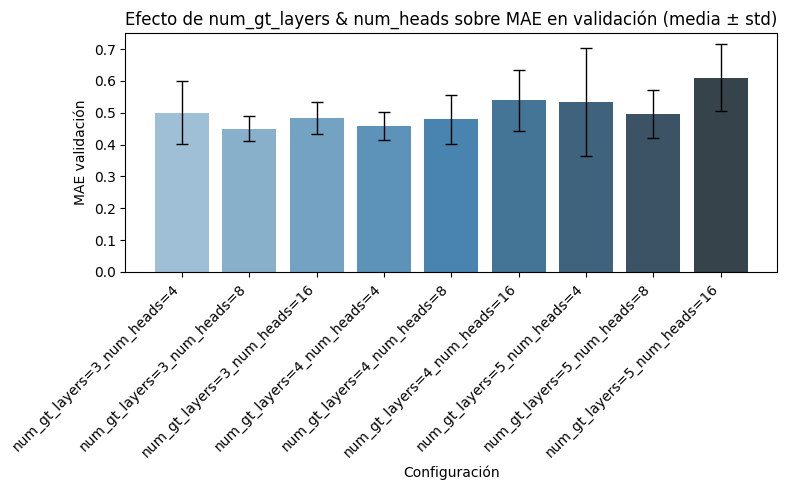

In [ ]:
# combos de layers × heads
comb_params = list(product([3, 4, 5], [4, 8, 16]))

df_comb = run_sweep_multiseed(
    ["num_gt_layers", "num_heads"],
    comb_params,
    defaults,
    max_epochs=300,
    seeds=[42, 1337, 2024, 2718, 31415],
    save_csv=True
)


In [ ]:
df = pd.read_csv("sweep_multiseed_num_gt_layers_num_heads.csv")
display(df)

config  num_gt_layers  num_heads  val_mae_mean  \
0   num_gt_layers=3_num_heads=4              3          4      0.500584   
1   num_gt_layers=3_num_heads=8              3          8      0.449516   
2  num_gt_layers=3_num_heads=16              3         16      0.484316   
3   num_gt_layers=4_num_heads=4              4          4      0.457773   
4   num_gt_layers=4_num_heads=8              4          8      0.479113   
5  num_gt_layers=4_num_heads=16              4         16      0.538899   
6   num_gt_layers=5_num_heads=4              5          4      0.533704   
7   num_gt_layers=5_num_heads=8              5          8      0.495021   
8  num_gt_layers=5_num_heads=16              5         16      0.610590   

   val_mae_std  test_mae_mean  test_mae_std  
0     0.099140       0.557385      0.090456  
1     0.039817       0.479963      0.049069  
2     0.050206       0.528101      0.062036  
3     0.043706       0.504604      0.034333  
4     0.076543       0.526831      0.070593  
5     0.094845       0.582515      0.099657  
6     0.169865       0.593138      0.162950  
7     0.074908       0.528206      0.090650  
8     0.104684       0.648910      0.140571

Podemos ver que al realizar más seeds de inicialización, aumentar el número de épocas y agregar parámetros de estabilidad al modelo, logramos reducir significativamente la varianza de los mejores modelos. Las dos combinaciones con menor MAE y baja varianza fueron:
- gt_layers = 3, num_heads = 8: Val MAE = 0.4495 ± 0.0398, Test MAE = 0.4800 ± 0.0491
- gt_layers = 4, num_heads = 4: Val MAE = 0.4578 ± 0.0437, Test MAE = 0.5046 ± 0.0343

Estos resultados sugieren que arquitecturas relativamente simples --con pocas capas y un número moderado de cabezas de atención-- se ajustan mejor al dataset disponible. En Graph Transformers, cada capa propaga información entre nodos vecinos; al aumentar la profundidad, las representaciones de los nodos comienzan a mezclarse hasta volverse similares entre sí (oversmoothing), perdiendo información local importante. En el contexto molecular, donde los grafos son pequeños, unas pocas capas bastan para cubrir toda la estructura relevante, por lo que profundizar más sólo difunde ruido y reduce la capacidad de generalización.

De manera análoga, un número excesivo de cabezas de atención introduce redundancia y dificulta la optimización del modelo. Al haber demasiadas cabezas activas, varias terminan aprendiendo patrones equivalentes o incluso contradictorios, lo que fragmenta el gradiente y ralentiza la convergencia. En cambio, un número moderado de cabezas favorece que cada una capture relaciones complementarias, manteniendo la eficiencia y estabilidad del entrenamiento.

En conjunto, estas configuraciones intermedias parecen alcanzar el mejor equilibrio entre expresividad y estabilidad. Utilizaremos estas dos combinaciones, junto con dropout entre 0.0 y 0.1, para definir cuatro configuraciones finales de prueba. El sweep sobre el dropout se justifica porque en las pruebas anteriores con dropout = 0.0 se observó un rendimiento superior al valor por defecto de 0.1; por tanto, se evaluarán ambas opciones para determinar si esta ventaja se mantiene de forma consistente.


=== Multi-seed sweep for ['num_gt_layers', 'num_heads', 'dropout'] ===

--- Testing num_gt_layers=3_num_heads=8_dropout=0.0 ---
Epoch 001 | Train: 4.3070 | Val: 3.2650 | Test: 3.1447
Epoch 010 | Train: 1.1608 | Val: 2.2730 | Test: 2.1541
Epoch 020 | Train: 0.6883 | Val: 1.2474 | Test: 1.2355
Epoch 030 | Train: 0.9035 | Val: 0.9731 | Test: 0.8801
Epoch 040 | Train: 0.7557 | Val: 1.0126 | Test: 0.8604
Epoch 050 | Train: 0.4108 | Val: 2.1984 | Test: 2.2109
Epoch 060 | Train: 0.4427 | Val: 0.9574 | Test: 0.7419
Epoch 070 | Train: 0.6409 | Val: 1.1124 | Test: 1.2408
Epoch 080 | Train: 0.4318 | Val: 0.8917 | Test: 0.8277
Epoch 090 | Train: 0.2369 | Val: 0.5796 | Test: 0.5391
Epoch 100 | Train: 0.3580 | Val: 0.5976 | Test: 0.6508
Epoch 110 | Train: 0.1825 | Val: 0.5138 | Test: 0.5335
Epoch 120 | Train: 0.1768 | Val: 0.5110 | Test: 0.5204
Epoch 130 | Train: 0.1399 | Val: 0.4842 | Test: 0.5013
Epoch 140 | Train: 0.1310 | Val: 0.5279 | Test: 0.5007
Epoch 150 | Train: 0.1104 | Val: 0.4821 | Test

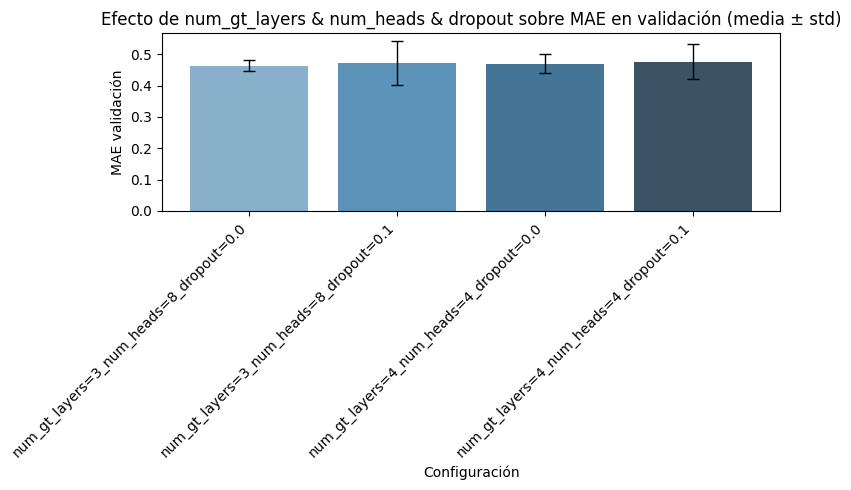

config  num_gt_layers  num_heads  dropout  \
0  num_gt_layers=3_num_heads=8_dropout=0.0              3          8      0.0   
2  num_gt_layers=4_num_heads=4_dropout=0.0              4          4      0.0   
1  num_gt_layers=3_num_heads=8_dropout=0.1              3          8      0.1   
3  num_gt_layers=4_num_heads=4_dropout=0.1              4          4      0.1   

   val_mae_mean  val_mae_std  test_mae_mean  test_mae_std  
0      0.463477     0.017363       0.530045      0.035041  
2      0.469490     0.030547       0.531764      0.032121  
1      0.470920     0.070184       0.525047      0.100659  
3      0.475576     0.056238       0.521545      0.063888

In [ ]:
best_pairs = [
    (3, 8),  # 3 layers, 8 heads
    (4, 4)   # 4 layers, 4 heads
]

def rerun_best_with_dropout(best_pairs, defaults, max_epochs=400,
                            seeds=[42, 1337, 2024, 2718, 31415, 1618, 73],
                            dropouts=(0.0, 0.1)):
    combos = [(L, H, d) for (L, H) in best_pairs for d in dropouts]
    df_final = run_sweep_multiseed(
        ["num_gt_layers", "num_heads", "dropout"],
        combos,
        defaults,
        max_epochs=max_epochs,
        seeds=list(seeds),
        save_csv=True
    )
    df_final = df_final.sort_values(["val_mae_mean", "val_mae_std"], ascending=[True, True])
    display(df_final)
    return df_final

df_final = rerun_best_with_dropout(best_pairs, defaults)

De los resultados, vemos que utilizar dropout = 0.0 mejoró el rendimiento y estabilidad en validación, y bajó significativamente la varianza en prueba. Técnicamente con dropout = 0.1 se obtuvo un menor MAE medio, pero la variación es muy alta, lo que lleva a concluir que la ganancia no es consistente.

Con los modelos con dropout = 0.0 se alcanzó un MAE medio de 0.530 (config 0: 3 capas, 8 cabezales) y 0.531 (config 2: 4 capas, 4 cabezales), con una desviación estándar de 0.035 (config 0) y 0.032 (config 1).

Si comparamos estos resultados con los del leaderboard del dataset, vemos que hay más modelos que tuvieron un mejor rendimiento. Este Graph Transformer se ubicaría en el puesto 20, con un rendimiento casi idéntico a NeuralFP, pero con mucha menor desviación estándar. En particular, vemos que este modelo supera a GCN, un modelo que hemos comparado directamente en clases.

Viendo al mejor modelo de la tabla, CaliciBoost, que alcanzó un MAE: 0.256 ± 0.006, vemos que además de utilizar técnicas sofisticadas de ML (como pipelines automáticos, AutoML) utilizan técnicas de extracción de features químicas en base a los datos de TDC (y OCHEM, pues incorporan un segundo dataset), con el fin de lograr mejores descriptores orientados específicamente a la tarea de regresión de permeabilidad Caco-2.

En definitiva, si bien la arquitecura elegida para este problema es definitivamente un factor importante a considerar, también lo es el preprocesamiento de los datos con conocimiento de dominio, de forma de amplificar features relevantes antes de entregarselas al modelo.

# Parte 3: Graphormer (20 puntos)

En esta tercera sección se debe trabajar con el dataset **PubMed**.

Este conjunto de datos está disponibles en pytorch-geometric. Ver enlace: https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html#torch_geometric.datasets.Planetoid

Antes de empezar, definiremos módulos generales a ambos tipos de Pooling. El código está basado en la implementación usada en clases de Graphormer + Pooling, adaptado para sustituir el cálculo de eigenvectores por una implementación más amigable con grafos grandes (Pubmed tiene ~20k nodos, mientras que Cora tenía solo ~2700).

In [88]:
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def laplacian_pe(edge_index, num_nodes, k, device):
    """Compute k smallest Laplacian eigenvectors safely with SciPy."""
    import numpy as np
    import scipy.sparse as sp
    from scipy.sparse.linalg import eigsh
    import torch.nn.functional as F

    # build sparse adjacency
    row, col = edge_index
    data = np.ones(row.numel(), dtype=np.float32)
    A = sp.coo_matrix((data, (row.cpu().numpy(), col.cpu().numpy())),
                      shape=(num_nodes, num_nodes))
    A = (A + A.T).tocsr()
    deg = np.array(A.sum(1)).flatten()

    # normalized Laplacian
    with np.errstate(divide='ignore'):
        deg_inv_sqrt = 1.0 / np.sqrt(deg)
    deg_inv_sqrt[np.isinf(deg_inv_sqrt)] = 0
    D_inv_sqrt = sp.diags(deg_inv_sqrt)
    L = sp.eye(num_nodes, format="csr") - D_inv_sqrt @ A @ D_inv_sqrt
    L = (L + L.T) * 0.5

    # smallest k eigenvectors
    eigvals, eigvecs = eigsh(L, k=k, which="SM", tol=1e-3, maxiter=5000)
    eigvecs = torch.from_numpy(eigvecs).float()
    eigvecs = F.normalize(eigvecs, p=2, dim=0)
    return eigvecs.to(device)

def degree_feature(edge_index, num_nodes, device):
    deg = torch.zeros(num_nodes, device=device)
    for src, dst in edge_index.t():
        deg[src] += 1
    return torch.log1p(deg).unsqueeze(-1)

def hard_assign(S: torch.Tensor):
    """Devuelve asignación dura (argmax)."""
    return S[0].argmax(dim=-1).detach().cpu()

@dataclass
class Config:
    seed: int = 42
    device: str = 'cuda' if torch.cuda.is_available() else 'cpu'
    dataset_name: str = 'PubMed'
    d_model: int = 128
    n_heads: int = 4
    n_layers: int = 3
    pe_dim: int = 8
    num_clusters: int = 128
    dropout: float = 0.1
    lr: float = 5e-4
    weight_decay: float = 5e-4
    epochs: int = 300
    pooling: str = 'diffpool'  # 'diffpool' o 'mincut'

Cargamos los datos y calculamos eigenvectores y grados

In [89]:
set_seed(42)
cfg = Config()
device = torch.device(cfg.device)

dataset = Planetoid(root=f'./data/{cfg.dataset_name}', name=cfg.dataset_name)
data = dataset[0].to(device)

A_dense = to_dense_adj(data.edge_index, max_num_nodes=data.num_nodes).to(device)

pe = laplacian_pe(data.edge_index.cpu(), data.num_nodes, cfg.pe_dim, torch.device("cpu"))
pe = pe.to(device)
deg_feat = degree_feature(data.edge_index, data.num_nodes, device)

print(f"Dataset: {cfg.dataset_name}")
print(f"Nodos: {data.num_nodes}, Features: {dataset.num_features}, Clases: {dataset.num_classes}")
print("PE shape:", tuple(pe.shape), "deg_feat shape:", tuple(deg_feat.shape))

Dataset: PubMed
Nodos: 19717, Features: 500, Clases: 3
PE shape: (19717, 8) deg_feat shape: (19717, 1)


Definimos los modelos generales a ambos métodos (DiffPool y MinCutPool)

In [90]:
# Encoder Graphormer-lite (TransformerConv + LapPE + grado)
class GraphormerLiteEncoder(nn.Module):
    def __init__(self, in_ch, d_model=128, n_heads=4, n_layers=3, pe_dim=16, dropout=0.1):
        super().__init__()
        self.lin_in = nn.Linear(in_ch + pe_dim + 1, d_model)
        self.layers = nn.ModuleList([
            TransformerConv(d_model, d_model // n_heads, heads=n_heads, dropout=dropout, beta=True)
            for _ in range(n_layers)
        ])
        self.norms = nn.ModuleList([nn.LayerNorm(d_model) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, edge_index, pe, deg_feat):
        h = torch.cat([x, pe, deg_feat], dim=-1)
        h = self.lin_in(h)
        for conv, ln in zip(self.layers, self.norms):
            h_res = h
            h = conv(h, edge_index)
            h = F.relu(h)
            h = self.dropout(h)
            h = ln(h + h_res)
        return h


# Modelo Graphormer-lite + Pooling jerárquico (DiffPool o MinCut)
class GraphormerLiteWithPooling(nn.Module):
    def __init__(self, in_ch, num_classes, d_model=128, n_heads=4, n_layers=3,
                 pe_dim=16, num_clusters=128, dropout=0.1, pooling='diffpool'):
        super().__init__()
        self.encoder = GraphormerLiteEncoder(in_ch, d_model, n_heads, n_layers, pe_dim, dropout)
        self.assigner = GCNConv(d_model, num_clusters)
        self.embedder = GCNConv(d_model, d_model)
        self.post_cluster = nn.Linear(d_model, d_model)
        self.classifier = nn.Linear(d_model, num_classes)
        self.pooling = pooling
        self.dropout = dropout

    def forward(self, data, A_dense, pe, deg_feat):
        H = self.encoder(data.x, data.edge_index, pe, deg_feat)
        Z = F.relu(self.embedder(H, data.edge_index))
        Z = F.normalize(Z, p=2, dim=-1)
        S = self.assigner(H, data.edge_index)


        Z = Z.unsqueeze(0)
        S_b = S.unsqueeze(0)

        if self.pooling == 'diffpool':
            X_pool, A_pool, link_loss, ent_loss = dense_diff_pool(Z, A_dense, S_b)
            reg_loss = link_loss + 1e-3 * ent_loss
        else:
            X_pool, A_pool, mc_loss, o_loss = dense_mincut_pool(Z, A_dense, S_b)
            reg_loss = mc_loss + 1e-3 * o_loss

        Hc = F.relu(self.post_cluster(X_pool))
        Hc = F.dropout(Hc, p=self.dropout, training=self.training)
        Hn = torch.matmul(S_b, Hc)[0]
        logits = self.classifier(Hn)
        return logits, Hn, S_b[0], reg_loss


## 3.1 Conceptos básicos (5 puntos)

Responda las siguientes preguntas:
1. ¿Que limitaciones del **Graph Attention Network** (GAT) intenta superar el Graphormer?
2. Describa las principales diferencias entre **Graphormer** y el **Graph Transformer original**.
3. Explique el concepto de **pooling** en el contexto de grafos. ¿En qué se diferencian **DiffPool** de **MinCutPool**?

Respuesta:

1.

El modelo GAT, si bien avanzado respecto a GCN al introducir atención variable, tiene limitaciones propias del acercamiento basado en convolución:
- Alcance local: Cada capa GAT permite incorporar información con sus vecinos directos (1-hop). Para incorporar información lejana, de nodos a distancia k, se necesitan k capas. Esto induce problemas de a) Oversmoothing, con las señales de todos los nodos volviéndose más homogéneas entre sí a medida pasan por el grafo y b) Alto número de parámetros, inducidos por la mayor cantidad de capas, lo cual obliga a incorporar más y mejores datos para evitar el sobreajuste de un modelo más grande.
- Ausencia de información estructural explícita: GAT es capaz de identificar únicamente si dos nodos están conectados o no, pero no las distancias entre ellos, ni las características topológicas que permitan asignar importancia a nodos según su rol o centralidad.

El Graphormer aborda estas limitaciones mediante modificaciones al mecanismo de atención y la incorporación de información estructural codificada:
- Alcance global: La atención deja de estar restringida al vecindario inmediato, permitiendo que todos los nodos se atiendan entre sí. Así se incorporan dependencias de largo alcance sin requerir más capas, mitigando el oversmoothing.
- Codificaciones estructurales: Introduce sesgos de atención que incorporan información topológica del grafo:
    - Spatial Encoding: agrega la distancia más corta entre nodos como sesgo en la atención.
    - Edge Encoding: incorpora información sobre el tipo o características de las aristas.
    - Centrality Encoding: incluye información sobre la relevancia de cada nodo según su grado o conectividad.

2.

El Graph Transformer introduce modificaciones sobre un Transformer convencional de NLP. En particular, adapta la capa de entrada para aceptar secuencias de nodos y aristas, utiliza embeddings derivados del Laplaciano para codificar el rol estructural de cada nodo dentro del grafo, y restringe el mecanismo de atención al vecindario local, lo que equivale a una forma de convolución atencional.
En definitiva, mantiene gran parte de la arquitectura original del Transformer, lo que introduce ciertas características --y limitaciones-- importantes:
- Secuencialización del grafo: El modelo recibe los nodos como una secuencia lineal, lo que obliga a definir un orden de recorrido que puede ser arbitrario o complejo para ciertos grafos.
- Sesgo posicional estructural: Para compensar la pérdida de información topológica por la secuencialización, el modelo incorpora embeddings posicionales derivados del Laplaciano, dependientes del orden de entrada y con posible ambigüedad.
- Atención local: Opera solo sobre los vecinos del nodo, como una GCN con pesos aprendibles.
- Información global limitada: Las dependencias de largo alcance se modelan solo mediante los LapPE.

En contraste, el Graphormer rediseña estos mecanismos para representar la estructura completa del grafo de manera más directa:
- Codificación estructural relacional: Reemplaza los embeddings laplacianos por encodings de espacialidad, arista y centralidad, que describen relaciones par-a-par entre nodos.
- Elimina la secuencialización: Procesa el grafo como un conjunto de nodos y relaciones, sin depender de un orden de entrada. La atención se modula con sesgos estructurales que garantizan invariancia a permutaciones.
- Atención global estructurada: Cada nodo puede atender a cualquier otro, con una intensidad regulada por los encodings estructurales, capturando dependencias locales y globales dentro del grafo.

3.

El pooling en el contexto de grafos busca reducir la complejidad del grafo conservando su estructura e información esencial. En lugar de procesar todos los nodos individualmente, el modelo agrupa nodos con roles o características similares en clusters, generando una versión más compacta y jerárquica del grafo. Esto permite capturar patrones estructurales a distintos niveles y facilita tareas como la clasificación o el análisis de comunidades.

DiffPool implementa este proceso de forma diferenciable, aprendiendo durante el entrenamiento cómo asignar cada nodo a un grupo. El modelo aprende directamente qué nodos deben unirse según sus representaciones y conexiones, pero requiere definir de antemano cuántos grupos formará. Esta restricción puede ser problemática, ya que el número óptimo de clusters depende de la estructura del grafo y no siempre es conocido. Además, las asignaciones pueden volverse poco precisas o demasiado difusas si no se controlan adecuadamente.

MinCutPool mantiene el mismo principio de aprendizaje de agrupamientos, pero introduce un criterio más estructural para guiar el proceso: la función de pérdida basada en el corte mínimo (min-cut). Esta función busca que los nodos que quedan dentro de un mismo cluster estén fuertemente conectados entre sí, mientras que las conexiones entre clusters distintos sean mínimas. En otras palabras, el modelo aprende a dividir el grafo en regiones internamente cohesivas y externamente separadas, de forma similar a cómo lo haría un algoritmo de partición de grafos clásico. Además, incluye un término adicional que promueve que los grupos sean equilibrados y distintos entre sí, evitando que todos los nodos se agrupen en un solo cluster. Así, MinCutPool logra un proceso de pooling más estable, guiado por la estructura real del grafo, y menos dependiente de decisiones externas como el número fijo de grupos.


Referencias:
- Clases 6, 7, 8 y 9 del curso.
- A Generalization of Transformer Networks to Graphs (https://arxiv.org/pdf/2012.09699)
- Do Transformers Really Perform Bad for Graph Representation? (https://arxiv.org/pdf/2106.05234)
- Spectral Clustering with Graph Neural Networks for Graph Pooling (https://arxiv.org/pdf/1907.00481)

## 3.2 DiffPool (5 puntos)

En esta sección se entrenará un modelo Graphormer utilizando el método de pooling jerárquico DiffPool. Para ello, siga los siguientes pasos:
1. Entrene un Graphormer con pooling jerárquico `DiffPool` con 300 épocas.
2. Por cada 20 épocas, reporte los siguientes indicadores:
    - Pérdida de clasificación
    - Regularización
    - Accuracy del test
    - NMI y ARI
    - Promedio tamaño de clusters ± desviación estandar
3. Entrene t-SNE sobre los nodos en el *embedding* final y sobre los centroides, y grafique los resultados. Finalmente, comente sus resultados.

Respuesta:

In [91]:
cfg.pooling = 'diffpool'

model = GraphormerLiteWithPooling(
    in_ch=dataset.num_features,
    num_classes=dataset.num_classes,
    d_model=cfg.d_model,
    n_heads=cfg.n_heads,
    n_layers=cfg.n_layers,
    pe_dim=cfg.pe_dim,
    num_clusters=cfg.num_clusters,
    dropout=cfg.dropout,
    pooling=cfg.pooling,
).to(device)

opt = Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

for epoch in range(1, cfg.epochs + 1):
    model.train()
    opt.zero_grad()
    logits, Hn, S, reg = model(data, A_dense, pe, deg_feat)
    loss_ce = F.cross_entropy(logits[data.train_mask], data.y[data.train_mask])
    loss = loss_ce + 1e-2 * reg
    loss.backward()
    opt.step()

    if epoch % 20 == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            logits, Hn, S, reg = model(data, A_dense, pe, deg_feat)
            pred = logits.argmax(dim=-1)
            acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()

            S_hard = S.argmax(dim=-1).detach().cpu().numpy()
            y_np = data.y.detach().cpu().numpy()
            ari = adjusted_rand_score(y_np, S_hard)
            nmi = normalized_mutual_info_score(y_np, S_hard)
            _, counts = np.unique(S_hard, return_counts=True)
            mean_size, std_size = counts.mean(), counts.std()

        print(f"[{cfg.pooling.upper()}][Epoch {epoch:03d}] "
              f"CE={loss_ce.item():.4f} Reg={reg.item():.4f} "
              f"Acc={acc:.4f} ARI={ari:.4f} NMI={nmi:.4f} "
              f"ClusterSize={mean_size:.1f}±{std_size:.1f}")

[DIFFPOOL][Epoch 001] CE=196.8689 Reg=0.0045 Acc=0.1800 ARI=0.0093 NMI=0.0161 ClusterSize=985.9±2569.8
[DIFFPOOL][Epoch 020] CE=6.4419 Reg=0.0047 Acc=0.4630 ARI=0.0011 NMI=0.0111 ClusterSize=821.5±1983.0
[DIFFPOOL][Epoch 040] CE=5.1878 Reg=0.0047 Acc=0.4300 ARI=-0.0019 NMI=0.0090 ClusterSize=985.9±3310.0
[DIFFPOOL][Epoch 060] CE=1.3525 Reg=0.0047 Acc=0.5380 ARI=0.0027 NMI=0.0134 ClusterSize=821.5±2358.4
[DIFFPOOL][Epoch 080] CE=5.7252 Reg=0.0047 Acc=0.5790 ARI=0.0043 NMI=0.0166 ClusterSize=597.5±1980.5
[DIFFPOOL][Epoch 100] CE=1.2223 Reg=0.0047 Acc=0.5870 ARI=0.0122 NMI=0.0227 ClusterSize=547.7±1136.9
[DIFFPOOL][Epoch 120] CE=2.0503 Reg=0.0047 Acc=0.6000 ARI=0.0252 NMI=0.0280 ClusterSize=469.5±1163.5
[DIFFPOOL][Epoch 140] CE=1.6634 Reg=0.0048 Acc=0.5210 ARI=0.0218 NMI=0.0263 ClusterSize=438.2±1378.4
[DIFFPOOL][Epoch 160] CE=1.1521 Reg=0.0048 Acc=0.4810 ARI=0.0088 NMI=0.0277 ClusterSize=438.2±1146.5
[DIFFPOOL][Epoch 180] CE=0.2884 Reg=0.0048 Acc=0.5850 ARI=0.0116 NMI=0.0279 ClusterSize=

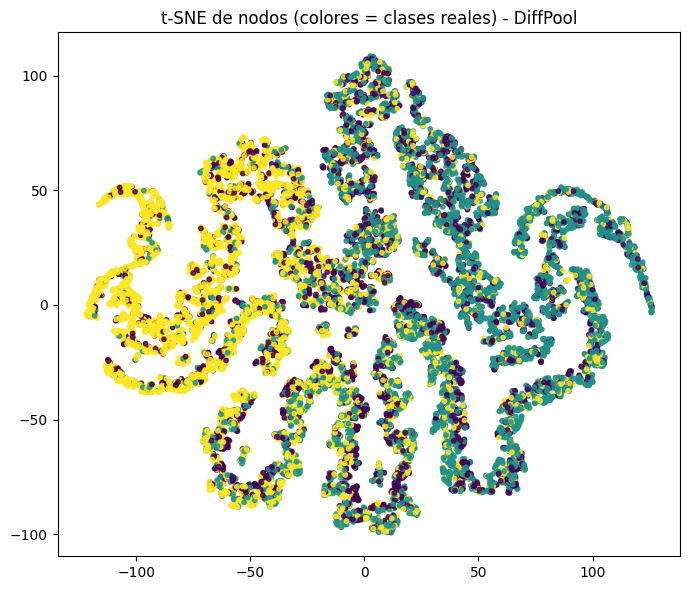

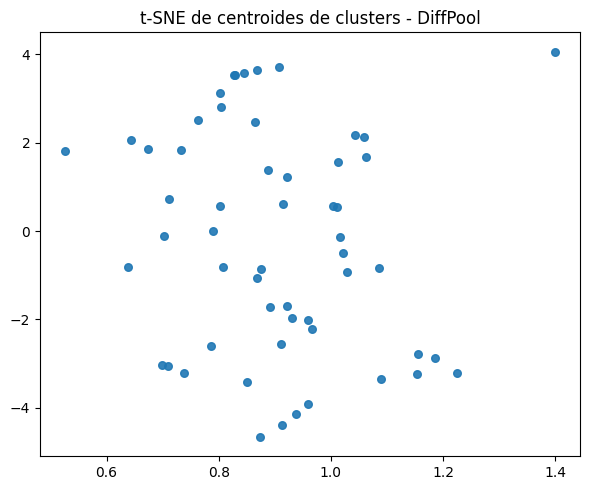

In [92]:
model.eval()
with torch.no_grad():
    logits, Hn, S, _ = model(data, A_dense, pe, deg_feat)
    clusters = S.argmax(dim=-1).detach().cpu().numpy()
    X_nodes = Hn.detach().cpu().numpy()
    y = data.y.detach().cpu().numpy()

# --- t-SNE de nodos ---
tsne_nodes = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                  init='pca', random_state=cfg.seed)
Z2_nodes = tsne_nodes.fit_transform(X_nodes)

plt.figure(figsize=(7,6))
plt.scatter(Z2_nodes[:,0], Z2_nodes[:,1], c=y, s=10, alpha=0.8)
plt.title('t-SNE de nodos (colores = clases reales) - DiffPool')
plt.tight_layout()
plt.show()
plt.close()

# --- t-SNE de centroides ---
K = S.size(1)
centroids = []
for k in range(K):
    idx = np.where(clusters == k)[0]
    if len(idx) == 0:
        continue
    centroids.append(X_nodes[idx].mean(axis=0))
centroids = np.stack(centroids, axis=0)

tsne_clusters = TSNE(n_components=2,
                     perplexity=min(30, max(5, len(centroids)//2)),
                     learning_rate='auto', init='pca',
                     random_state=cfg.seed)
Z2_clusters = tsne_clusters.fit_transform(centroids)

plt.figure(figsize=(6,5))
plt.scatter(Z2_clusters[:,0], Z2_clusters[:,1], s=30, alpha=0.9)
plt.title('t-SNE de centroides de clusters - DiffPool')
plt.tight_layout()
plt.savefig('tsne_clusters.png', dpi=200)
plt.show()
plt.close()


In [93]:
S_hard = S.argmax(dim=-1).cpu().numpy()
used = np.unique(S_hard)
print("used clusters:", used.size, " / K =", S.size(1), "empty:", S.size(1)-used.size)

used clusters: 55  / K = 128 empty: 73


#### Comentario sobre los resultados del modelo con DiffPool  

Durante el entrenamiento con DiffPool se observó una convergencia relativamente estable de la pérdida de clasificación, disminuyendo progresivamente hasta valores cercanos a 0.2–0.3. La regularización se mantuvo casi constante alrededor de 0.0048, lo que sugiere un proceso de agrupamiento suave y sin grandes oscilaciones.  

El accuracy de test aumentó gradualmente hasta estabilizarse en torno al 52–58%, sin mostrar una mejora significativa más allá de las 200 épocas. Las métricas de clustering (ARI y NMI) permanecieron cercanas a 0, indicando una baja correlación entre los clusters generados y las clases reales, lo cual es esperable dada la gran diferencia entre el número de clusters (128) y el número de clases (3).  

Al observar los gráficos t-SNE, los embeddings de nodos muestran una distribución dispersa y con alto traslape entre clases, sin fronteras claras. Los centroides de los clusters aparecen muy agrupados, indicando que varios clusters aprendidos son similares entre sí. Además, solo 55 de los 128 clusters posibles fueron efectivamente utilizados, con un tamaño promedio de 358.5±990.5, lo que sugiere una ocupación relativamente más equilibrada pero aún irregular.  

En conjunto, los resultados sugieren que DiffPool logra una representación jerárquica estable, pero no necesariamente informativa para la clasificación de nodos.


## 3.3 MinCutPool (5 puntos)

En esta sección se entrenará un modelo Graphormer utilizando el método de pooling jerárquico MinCut. Para ello, siga los siguientes pasos:
1. Entrene un Graphormer con pooling jerárquico `MinCutPool` con 300 épocas.
2. Por cada 20 épocas, reporte los siguientes indicadores:
    - Pérdida de clasificación
    - Regularización
    - Accuracy del test
    - NMI y ARI
    - Promedio tamaño de clusters ± desviación estandar
3. Entrene t-SNE sobre los nodos en el *embedding* final y sobre los centroides, y grafique los resultados. Finalmente, comente sus resultados.

Respuesta:

In [94]:
cfg.pooling = 'mincut'

model = GraphormerLiteWithPooling(
    in_ch=dataset.num_features,
    num_classes=dataset.num_classes,
    d_model=cfg.d_model,
    n_heads=cfg.n_heads,
    n_layers=cfg.n_layers,
    pe_dim=cfg.pe_dim,
    num_clusters=cfg.num_clusters,
    dropout=cfg.dropout,
    pooling=cfg.pooling,
).to(device)

opt = Adam(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)

for epoch in range(1, cfg.epochs + 1):
    model.train()
    opt.zero_grad()
    logits, Hn, S, reg = model(data, A_dense, pe, deg_feat)
    loss_ce = F.cross_entropy(logits[data.train_mask], data.y[data.train_mask])
    loss = loss_ce + 1e-2 * reg
    loss.backward()
    opt.step()

    if epoch % 20 == 0 or epoch == 1:
        model.eval()
        with torch.no_grad():
            logits, Hn, S, reg = model(data, A_dense, pe, deg_feat)
            pred = logits.argmax(dim=-1)
            acc = (pred[data.test_mask] == data.y[data.test_mask]).float().mean().item()

            S_hard = S.argmax(dim=-1).detach().cpu().numpy()
            y_np = data.y.detach().cpu().numpy()
            ari = adjusted_rand_score(y_np, S_hard)
            nmi = normalized_mutual_info_score(y_np, S_hard)
            _, counts = np.unique(S_hard, return_counts=True)
            mean_size, std_size = counts.mean(), counts.std()

        print(f"[{cfg.pooling.upper()}][Epoch {epoch:03d}] "
              f"CE={loss_ce.item():.4f} Reg={reg.item():.4f} "
              f"Acc={acc:.4f} ARI={ari:.4f} NMI={nmi:.4f} "
              f"ClusterSize={mean_size:.1f}±{std_size:.1f}")

[MINCUT][Epoch 001] CE=321.7045 Reg=-0.5144 Acc=0.1800 ARI=0.0112 NMI=0.0117 ClusterSize=938.9±2255.5
[MINCUT][Epoch 020] CE=16.1414 Reg=-0.4866 Acc=0.1800 ARI=-0.0044 NMI=0.0080 ClusterSize=2190.8±3678.9
[MINCUT][Epoch 040] CE=6.4675 Reg=-0.7647 Acc=0.1930 ARI=0.0041 NMI=0.0180 ClusterSize=821.5±1892.8
[MINCUT][Epoch 060] CE=4.5703 Reg=-0.7942 Acc=0.4780 ARI=0.0141 NMI=0.0210 ClusterSize=788.7±2005.6
[MINCUT][Epoch 080] CE=6.6202 Reg=-0.6475 Acc=0.5060 ARI=0.0080 NMI=0.0103 ClusterSize=938.9±2641.4
[MINCUT][Epoch 100] CE=0.8688 Reg=-0.8251 Acc=0.5020 ARI=0.0140 NMI=0.0230 ClusterSize=616.2±1446.9
[MINCUT][Epoch 120] CE=4.4342 Reg=-0.8420 Acc=0.5100 ARI=0.0088 NMI=0.0193 ClusterSize=563.3±1342.3
[MINCUT][Epoch 140] CE=0.7260 Reg=-0.8307 Acc=0.5250 ARI=0.0125 NMI=0.0236 ClusterSize=616.2±1337.9
[MINCUT][Epoch 160] CE=1.0941 Reg=-0.8291 Acc=0.4690 ARI=0.0131 NMI=0.0310 ClusterSize=616.2±1552.3
[MINCUT][Epoch 180] CE=1.5060 Reg=-0.8057 Acc=0.5060 ARI=0.0180 NMI=0.0338 ClusterSize=657.2±19

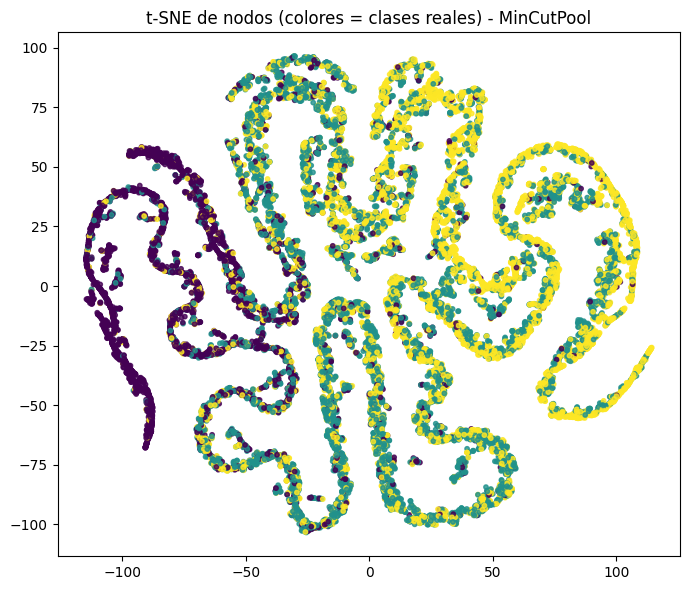

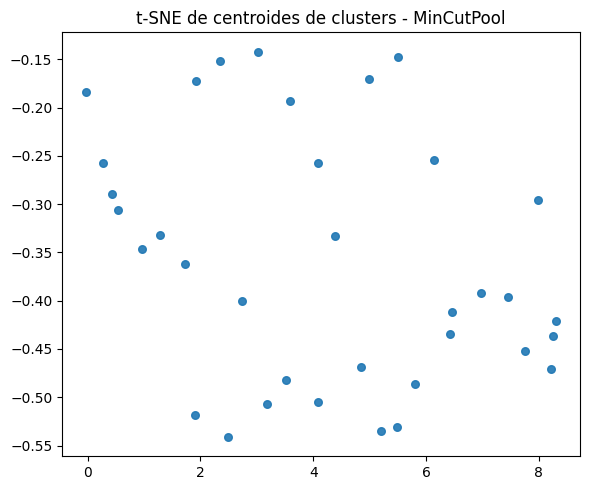

In [95]:
model.eval()
with torch.no_grad():
    logits, Hn, S, _ = model(data, A_dense, pe, deg_feat)
    clusters = S.argmax(dim=-1).detach().cpu().numpy()
    X_nodes = Hn.detach().cpu().numpy()
    y = data.y.detach().cpu().numpy()

# --- t-SNE de nodos ---
tsne_nodes = TSNE(n_components=2, perplexity=30, learning_rate='auto',
                  init='pca', random_state=cfg.seed)
Z2_nodes = tsne_nodes.fit_transform(X_nodes)

plt.figure(figsize=(7,6))
plt.scatter(Z2_nodes[:,0], Z2_nodes[:,1], c=y, s=10, alpha=0.8)
plt.title('t-SNE de nodos (colores = clases reales) - MinCutPool')
plt.tight_layout()
plt.savefig('tsne_nodes.png', dpi=200)
plt.show()
plt.close()

# --- t-SNE de centroides ---
K = S.size(1)
centroids = []
for k in range(K):
    idx = np.where(clusters == k)[0]
    if len(idx) == 0:
        continue
    centroids.append(X_nodes[idx].mean(axis=0))
centroids = np.stack(centroids, axis=0)

tsne_clusters = TSNE(n_components=2,
                     perplexity=min(30, max(5, len(centroids)//2)),
                     learning_rate='auto', init='pca',
                     random_state=cfg.seed)
Z2_clusters = tsne_clusters.fit_transform(centroids)

plt.figure(figsize=(6,5))
plt.scatter(Z2_clusters[:,0], Z2_clusters[:,1], s=30, alpha=0.9)
plt.title('t-SNE de centroides de clusters - MinCutPool')
plt.tight_layout()
plt.savefig('tsne_clusters.png', dpi=200)
plt.show()
plt.close()


In [96]:
S_hard = S.argmax(dim=-1).cpu().numpy()
used = np.unique(S_hard)
print("used clusters:", used.size, " / K =", S.size(1), "empty:", S.size(1)-used.size)

used clusters: 35  / K = 128 empty: 93


#### Comentario sobre los resultados del modelo con MinCutPool  

Durante el entrenamiento con MinCutPool se observó una convergencia más irregular que en DiffPool, con una pérdida de clasificación que fluctuó entre valores altos y bajos antes de estabilizarse cerca de 0.3. La pérdida de regularización se mantuvo negativa (~−0.8), lo cual es coherente con el criterio del método basado en minimizar el corte normalizado entre clusters.  

El accuracy alcanzó valores similares al modelo anterior, con un máximo cercano al 60%, pero con una ligera mejora en las métricas de clustering (ARI≈0.018 y NMI≈0.045). Esto indica que los clusters presentan una estructura más alineada con las relaciones internas del grafo, aunque sin reflejar claramente las clases reales.  

En los gráficos t-SNE, se aprecia una mejor organización visual: los nodos forman regiones más definidas y con menos traslape entre clases. Los centroides de los clusters están más separados entre sí, sugiriendo una mayor diferenciación estructural. En este caso, solo 35 de los 128 clusters fueron efectivamente utilizados, con un tamaño promedio de 563.3±1987.9, lo que refleja una fuerte desigualdad en la ocupación: algunos clusters agrupan muchos nodos, mientras que otros quedan casi vacíos.  

En general, MinCutPool produce agrupamientos más coherentes topológicamente y concentrados, aunque con alta varianza en tamaño y sin una ganancia sustancial en clasificación.


## 3.4 Conclusiones: DiffPool vs MinCutPool (5 puntos)

* ¿Qué modelo obtuvo mejor accuracy, NMI o ARI?

* ¿Qué diferencias se observaron en la convergencia de las pérdidas entre DiffPool y MinCutPool?

* ¿Hubo una diferencia clara en la capacidad de los modelos para formar clusters coherentes?

* ¿Cuál método mostró una mejor separación de clases en los gráficos t-SNE?

* ¿Cuál de los métodos recomendarías para este tipo de tarea y por qué?

Respuesta:

#### ¿Qué modelo obtuvo mejor accuracy, NMI o ARI?  
- Entre ambos modelos, el mejor accuracy de clasificación lo obtuvo el graphormer con MinCutPool. Tanto en cuanto al mejor accuracy alcanzado durante el entrenamiento, como la convergencia hacia el accuracy final. Lo mismo para ARI y NMI: MinCutPool obtuvo (marginalmente) mejores cifras en ambas métricas: ARI=0.0184 y NMI=0.0454 (MinCutPool), versus ARI=0.0148 NMI=0.0276 (DiffPool).  

    No obstante, estas métricas son poco significativas, sobretodo si consideramos el intervalo definido para ambas. ARI fluctúa entre -1 y 1, y mide el nivel de concordancia entre clusters y labels reales. Un valor cercano a 0 (como es el caso aquí), indica que no existe relación, y que la asignación es prácticamente aleatoria. No es particularmente mala (un valor negativo indica que los clusters indican una relación peor que el azar entre clusters y labels), pero sí indica que no es significativa respecto a las etiquetas reales. Esto tiene sentido si se considera la discordancia entre 128 clusters y 3 clases reales. Naturalmente, la forma en que se formula la métrica no permite que exista concordancia.  

    La conclusión es similar sobre el NMI. Esta métrica fluctúa entre 0 y 1, donde 0 indica que los clusters no explican las clases reales.  

#### ¿Qué diferencias se observaron en la convergencia de las pérdidas entre DiffPool y MinCutPool?  
- DiffPool mostró una convergencia más estable en la pérdida de clasificación (Cross-Entropy), disminuyendo gradualmente hasta estabilizarse alrededor de 0.2–0.3. El valor de “Reg”, correspondiente a la pérdida de regularización (link prediction + entropía), se mantuvo prácticamente constante (~0.0048), lo que refleja una dinámica de pooling suave y homogénea.  

    En contraste, MinCutPool presentó una pérdida de regularización negativa y de mayor magnitud (≈ -0.8), coherente con su formulación basada en minimizar el corte normalizado entre clusters. Aunque su convergencia fue más ruidosa, alcanzó valores de accuracy ligeramente superiores y clusters más diferenciados estructuralmente.  

    Además, DiffPool obtuvo una menor varianza final en el tamaño de los clusters, indicando una asignación más uniforme, mientras que MinCutPool produjo clusters más desbalanceados pero con conectividad interna más fuerte (ver Spectral Clustering with Graph Neural Networks for Graph Pooling).  

#### ¿Hubo una diferencia clara en la capacidad de los modelos para formar clusters coherentes?  
- Sí. Aunque ambos modelos generaron clusters con alta varianza en su tamaño, MinCutPool mostró una mayor coherencia estructural. DiffPool tiende a crear asignaciones más suaves y redundantes, mientras que MinCutPool, al optimizar un criterio de corte mínimo, promueve grupos internamente densos y externamente más aislados.  

    En términos generales, MinCutPool logra una segmentación estructural más clara, aunque no necesariamente alineada con las clases reales. DiffPool, por el contrario, produce clusters más uniformes pero menos informativos desde el punto de vista topológico.  

#### ¿Cuál método mostró una mejor separación de clases en los gráficos t-SNE?  
- De ambos métodos, MinCutPool muestra la mejor separación de clases cuando consideramos el gráfico t-SNE. No solo los patrones de "brazos" en el gráfico son más definidos (lo cual nos lleva a suponer que existen fronteras claras entre clusters y menos traslape entre ellos), sino que la distribución de las 3 clases reales está mejor organizada en el segundo gráfico: la clase morada se ubica definidamente en los brazos de la izquierda, mientras que en el gráfico de DiffPool la distribución de la clase morada es completamente caótica. Podría argumentarse que el primer gráfico muestra una distribución más dividida entre la clase amarilla y la clase verde, pero no es tan directo afirmarlo debido a su baja definición.  

    Por otro lado, desde los gráficos de t-SNE de centroides, también podemos notar que con MinCutPool se logró una mejor separación entre clusters. En comparación, en el primer gráfico de DiffPool existen varios centroides cercanos entre sí, lo que indica cierto nivel de sobrelape entre clusters.  

    Esto tiene sentido si consideramos que MinCutPool, mediante su criterio de corte mínimo, está diseñado para producir clusters con alta conexión interna y con mayor aislamiento externo (ver Spectral Clustering with Graph Neural Networks for Graph Pooling).  

#### ¿Cuál de los métodos recomendarías para este tipo de tarea y por qué?  
- Para una tarea de clasificación de nodos, no recomendaría utilizar ni DiffPool ni MinCutPool. Ambos métodos fueron diseñados para clasificación de grafos completos, donde la representación jerárquica tiene sentido (ver Hierarchical Graph Representation Learning with Differentiable Pooling). En PubMed, esta reducción degrada la resolución individual de los nodos y disminuye el rendimiento.  

    Si el objetivo es obtener mayor accuracy de clasificación de nodos, el modelo propuesto por el equipo que desarrolló el GCN logra mejores resultados (~79%) sin pérdida de información estructural. En cambio, si se busca analizar jerarquías o comunidades a nivel de grafo, MinCutPool sería la opción más apropiada.  

#### Reflexión final  
Un punto relevante que vale la pena mencionar, es que el acercamiento de representación jerárquica de grafos usualmente es utilizado para tareas que se relacionan con características a nivel de grafo. Por ejemplo, clasificación de grafos (como distintos tipos de moléculas, donde cada grafo pertenece a una categoría). La manera en que lo estamos utilizando aquí —coarsening y agregación de grafos, para clasificación de nodos— es un setup poco usual. Se podría incluso decir que la agregación desde 20k nodos a solo 128 clusters congrega nodos con importantes diferencias: el modelo está perdiendo su capacidad de discriminar a nivel de nodo.  

Es cierto que aumentar el número de clusters producidos, desde 128 a 512 por ejemplo, puede mejorar levemente el accuracy de clasificación, bajo el supuesto de que los clusters producidos sean significativos. Pero desde este punto, se empieza a perder el sentido de realizar pooling: si se crean muchos clusters, además con mucha varianza en cuanto a su nivel de ocupación, el modelo pierde su capacidad de establecer relaciones jerárquicas que agrupen nodos.  

Al probar distintos parámetros, incluido el número de clusters, se encontró que al menos para esta tarea existe un balance entre accuracy de clasificación y significancia del clustering: a medida que los parámetros se optimizan para elevar el accuracy (por ejemplo, más clusters), el clustering pierde calidad y significancia, lo que en turno afecta el accuracy debido a que las representaciones con las que trabaja el clasificador pierden calidad. Y en la otra dirección, si se optimizan los parámetros para generar clusters alineados con las clases (por ejemplo, menos clusters), se pierden muchas características finas y la clasificación empeora también. Dicho esto, es muy probable que otro método sin pooling obtenga mejores resultados en este problema.  

Referencias:  
- Spectral Clustering with Graph Neural Networks for Graph Pooling (https://arxiv.org/pdf/1907.00481)  
- Semi-Supervised Classification with Graph Convolutional Networks (https://arxiv.org/pdf/1609.02907)  
- Hierarchical Graph Representation Learning with Differentiable Pooling (https://arxiv.org/pdf/1806.08804)  
